#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [4]:
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [5]:
import pandas as pd

# 데이터프레임 예시 (실제 데이터에 맞게 수정 필요)
# orders 데이터프레임
orders_m = pd.DataFrame(orders)

# sales 데이터프레임
sales_m = pd.DataFrame(sales)

# products 데이터프레임
products_m = pd.DataFrame(products)

# stores 데이터프레임
stores_m = pd.DataFrame(stores)

# 데이터프레임 병합 (Date 및 Store_ID 기준으로 orders와 sales 병합)
merged_data = orders_m.merge(sales_m, on=['Date', 'Store_ID'])

# products 데이터프레임과 Product_ID로 병합
merged_data = merged_data.merge(products_m, on='Product_ID')

# stores 데이터프레임과 Store_ID로 병합
merged_data = merged_data.merge(stores_m, on='Store_ID')

# 결과 출력
merged_data

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-01,25,840,1415.000,3,DB001,Beverage,Drink,2,8,Olympia,Washington,4
1,2014-01-01,25,840,186.452,5,FB001,BAKERY,Food,2,6,Olympia,Washington,4
2,2014-01-01,25,840,232.000,7,HC001,Cleaning,Household Goods,2,15,Olympia,Washington,4
3,2014-01-01,25,840,358.000,8,FM001,Yogurt,Food,2,4,Olympia,Washington,4
4,2014-01-01,25,840,64.000,10,GE001,EGGS,Grocery,2,5,Olympia,Washington,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
864511,2017-02-28,54,729,24.000,38,DA001,Wine,Drink,2,12,LA,\tCalifornia,3
864512,2017-02-28,54,729,49.222,24,GM001,Meats,Grocery,3,17,LA,\tCalifornia,3
864513,2017-02-28,54,729,12.000,27,HH001,Home Appliances,Household Goods,2,150,LA,\tCalifornia,3
864514,2017-02-28,54,729,59.000,29,FP001,Prepared,Food,2,18,LA,\tCalifornia,3


In [100]:
# 병합된 데이터프레임을 CSV 파일로 저장
#merged_data.to_csv('/content/drive/MyDrive/project/merged_data.csv', index=False)

In [6]:
df = merged_data

In [7]:
# 첫 번째: 요일 추가
df['Date'] = pd.to_datetime(df['Date']) # Date 열이 datetime 형식이 아닌 경우
df['Weekday'] = df['Date'].dt.day_name() # 요일 추가

# 첫 번째 데이터프레임 (요일 추가) 저장
df_weekday = df.copy()
df_weekday.to_csv(path + 'weekday_data.csv', index=False)

# 결과 확인
print("첫 번째 데이터프레임 (요일 추가):")
print(df_weekday.head())

첫 번째 데이터프레임 (요일 추가):
        Date  Store_ID  CustomerCount       Qty  Product_ID Product_Code  \
0 2014-01-01        25            840  1415.000           3        DB001   
1 2014-01-01        25            840   186.452           5        FB001   
2 2014-01-01        25            840   232.000           7        HC001   
3 2014-01-01        25            840   358.000           8        FM001   
4 2014-01-01        25            840    64.000          10        GE001   

  SubCategory         Category  LeadTime  Price     City       State  \
0    Beverage            Drink         2      8  Olympia  Washington   
1      BAKERY             Food         2      6  Olympia  Washington   
2    Cleaning  Household Goods         2     15  Olympia  Washington   
3      Yogurt             Food         2      4  Olympia  Washington   
4        EGGS          Grocery         2      5  Olympia  Washington   

   Store_Type    Weekday  
0           4  Wednesday  
1           4  Wednesday  
2       

In [8]:
# 두 번째: 평일/주말 구분 추가
df['Day_Type'] = df['Weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# 두 번째 데이터프레임 (평일/주말 추가) 저장
df_day_type = df.copy()
df_day_type.to_csv(path + 'day_type_data.csv', index=False)

print("\n두 번째 데이터프레임 (평일/주말 추가):")
print(df_day_type.head())


두 번째 데이터프레임 (평일/주말 추가):
        Date  Store_ID  CustomerCount       Qty  Product_ID Product_Code  \
0 2014-01-01        25            840  1415.000           3        DB001   
1 2014-01-01        25            840   186.452           5        FB001   
2 2014-01-01        25            840   232.000           7        HC001   
3 2014-01-01        25            840   358.000           8        FM001   
4 2014-01-01        25            840    64.000          10        GE001   

  SubCategory         Category  LeadTime  Price     City       State  \
0    Beverage            Drink         2      8  Olympia  Washington   
1      BAKERY             Food         2      6  Olympia  Washington   
2    Cleaning  Household Goods         2     15  Olympia  Washington   
3      Yogurt             Food         2      4  Olympia  Washington   
4        EGGS          Grocery         2      5  Olympia  Washington   

   Store_Type    Weekday Day_Type  
0           4  Wednesday  Weekday  
1           4

In [9]:
df_weekday

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday
0,2014-01-01,25,840,1415.000,3,DB001,Beverage,Drink,2,8,Olympia,Washington,4,Wednesday
1,2014-01-01,25,840,186.452,5,FB001,BAKERY,Food,2,6,Olympia,Washington,4,Wednesday
2,2014-01-01,25,840,232.000,7,HC001,Cleaning,Household Goods,2,15,Olympia,Washington,4,Wednesday
3,2014-01-01,25,840,358.000,8,FM001,Yogurt,Food,2,4,Olympia,Washington,4,Wednesday
4,2014-01-01,25,840,64.000,10,GE001,EGGS,Grocery,2,5,Olympia,Washington,4,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864511,2017-02-28,54,729,24.000,38,DA001,Wine,Drink,2,12,LA,\tCalifornia,3,Tuesday
864512,2017-02-28,54,729,49.222,24,GM001,Meats,Grocery,3,17,LA,\tCalifornia,3,Tuesday
864513,2017-02-28,54,729,12.000,27,HH001,Home Appliances,Household Goods,2,150,LA,\tCalifornia,3,Tuesday
864514,2017-02-28,54,729,59.000,29,FP001,Prepared,Food,2,18,LA,\tCalifornia,3,Tuesday


In [10]:
df_day_type

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type
0,2014-01-01,25,840,1415.000,3,DB001,Beverage,Drink,2,8,Olympia,Washington,4,Wednesday,Weekday
1,2014-01-01,25,840,186.452,5,FB001,BAKERY,Food,2,6,Olympia,Washington,4,Wednesday,Weekday
2,2014-01-01,25,840,232.000,7,HC001,Cleaning,Household Goods,2,15,Olympia,Washington,4,Wednesday,Weekday
3,2014-01-01,25,840,358.000,8,FM001,Yogurt,Food,2,4,Olympia,Washington,4,Wednesday,Weekday
4,2014-01-01,25,840,64.000,10,GE001,EGGS,Grocery,2,5,Olympia,Washington,4,Wednesday,Weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
864511,2017-02-28,54,729,24.000,38,DA001,Wine,Drink,2,12,LA,\tCalifornia,3,Tuesday,Weekday
864512,2017-02-28,54,729,49.222,24,GM001,Meats,Grocery,3,17,LA,\tCalifornia,3,Tuesday,Weekday
864513,2017-02-28,54,729,12.000,27,HH001,Home Appliances,Household Goods,2,150,LA,\tCalifornia,3,Tuesday,Weekday
864514,2017-02-28,54,729,59.000,29,FP001,Prepared,Food,2,18,LA,\tCalifornia,3,Tuesday,Weekday


In [11]:
df_day_type['Day_Type'].value_counts()

,count
Day_Type,
Weekday,617994
Weekend,246522


In [12]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [14]:
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [15]:
import sys

# # Google Colab 환경에서 실행 중인지 확인
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninteractive' | \
  debconf-set-selections
# debconf를 Noninteractive 모드로 설정

#     # fonts-nanum 패키지를 설치
!sudo apt-get -qq -y install fonts-nanum

#     # Matplotlib의 폰트 매니저 가져오기
import matplotlib.font_manager as fm

#     # 나눔 폰트의 시스템 경로 찾기
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])

#     # 찾은 각 나눔 폰트를 Matplotlib 폰트 매니저에 추가
for fpath in font_files:
  fm.fontManager.addfont(fpath)

In [16]:
!apt-get install -y fonts-nanum*
!rm -rf /root/.cache/matplotlib/* # 폰트 캐시 재설정
# 런타임 다시 시작 후 실행
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
#
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = mpl.font_manager.FontProperties(fname=path).get_name()
plt.rcParams['font.family'] = font_name

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'fonts-nanum-extra' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-coding' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum-eco' for glob 'fonts-nanum*'
Note, selecting 'fonts-nanum' for glob 'fonts-nanum*'
fonts-nanum is already the newest version (20200506-1).
fonts-nanum-coding is already the newest version (2.5-3).
fonts-nanum-eco is already the newest version (1.000-7).
fonts-nanum-extra is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [17]:
#!unzip /content/drive/MyDrive/project/merge_product.zip -d /content/drive/MyDrive/project/

## **(1) 상품 : 3 - Beverage**

In [49]:
product_3 = pd.read_csv(path + 'product_3_data.csv')

In [50]:
product_3.head()

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-01,25,840,1415.0,3,DB001,Beverage,Drink,2,8,Olympia,Washington,4
1,2014-01-01,36,487,760.0,3,DB001,Beverage,Drink,2,8,Wilmington,\tNorth Carolina,5
2,2014-01-02,1,1875,2524.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4
3,2014-01-02,2,2122,3190.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4
4,2014-01-02,3,3350,9136.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4


           Date  Store_ID      Qty Day_Type  DayType_Sales
585  2014-01-02        44   9853.0  Weekday    7109.454545
1291 2014-01-03        44   8647.0  Weekday    7109.454545
1997 2014-01-04        44  15153.0  Weekend   13476.000000
2703 2014-01-05        44  15606.0  Weekend   13476.000000
3409 2014-01-06        44   7900.0  Weekday    7109.454545


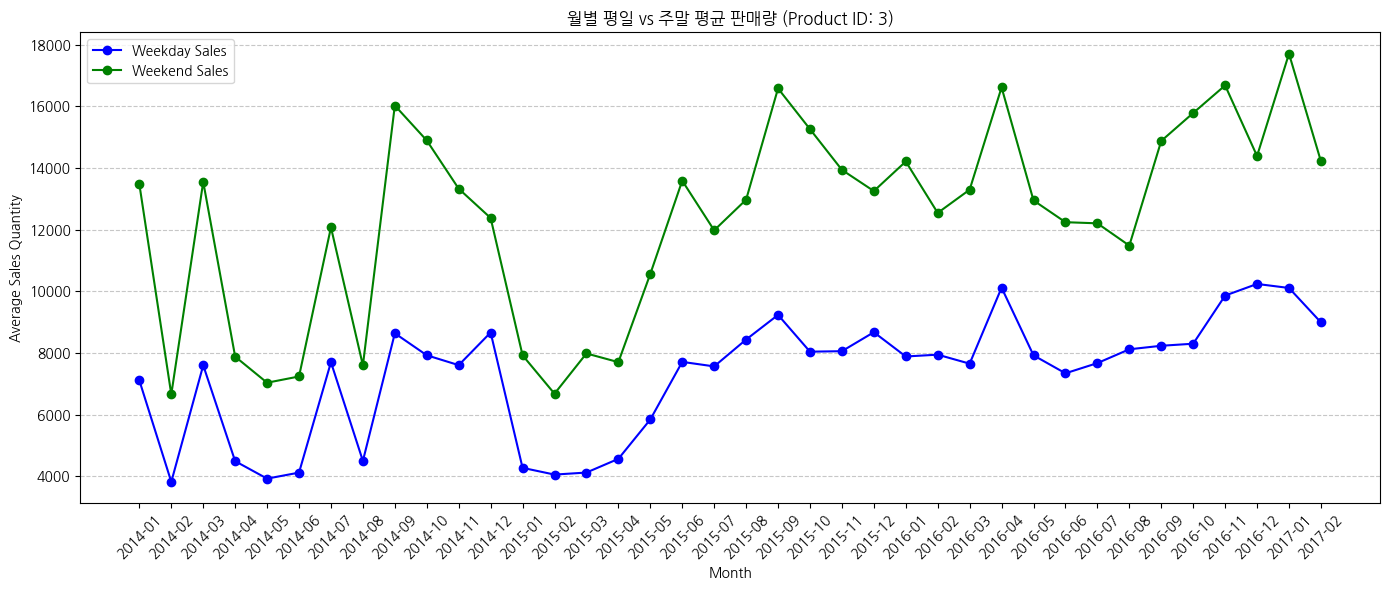

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Store_ID 44, Product_ID 12 필터링
store_id = 44
product_ids = [3]  # 상품 번호 리스트

df_filtered = df[(df['Store_ID'] == store_id) & (df['Product_ID'].isin(product_ids))]

# 날짜 형식을 datetime으로 변환
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# 요일 및 평일/주말 구분 추가
df_filtered['Weekday'] = df_filtered['Date'].dt.day_name()
df_filtered['Day_Type'] = df_filtered['Weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# 월별 평일 판매량 집계
weekday_sales = df_filtered[df_filtered['Day_Type'] == 'Weekday'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekday_sales.columns = ['Month', 'Weekday_Sales']
weekday_sales['Month'] = weekday_sales['Month'].astype(str)  # 문자열로 변환

# 월별 주말 판매량 집계
weekend_sales = df_filtered[df_filtered['Day_Type'] == 'Weekend'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekend_sales.columns = ['Month', 'Weekend_Sales']
weekend_sales['Month'] = weekend_sales['Month'].astype(str)  # 문자열로 변환

# 병합하여 하나의 데이터프레임으로 만들기 (월별 평일/주말 판매량)
monthly_sales = pd.merge(weekday_sales, weekend_sales, on='Month', how='outer').fillna(0)

# 'Month' 열을 문자열로 변환하여 병합 준비
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# DayType_Sales 열 추가
df_filtered['DayType_Sales'] = df_filtered.apply(
    lambda row: monthly_sales[monthly_sales['Month'] == row['Month']]['Weekday_Sales'].values[0]
    if row['Day_Type'] == 'Weekday'
    else monthly_sales[monthly_sales['Month'] == row['Month']]['Weekend_Sales'].values[0],
    axis=1
)

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales']].head())

# 월별 평일/주말 판매량 그래프 시각화 (선택 사항)
plt.figure(figsize=(14, 6))

# 평일 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekday_Sales'], label='Weekday Sales', marker='o', color='blue')

# 주말 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekend_Sales'], label='Weekend Sales', marker='o', color='green')

plt.title('월별 평일 vs 주말 평균 판매량 (Product ID: 3)')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales
585,2014-01-02,44,4422,9853.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7109.454545
1291,2014-01-03,44,4167,8647.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7109.454545
1997,2014-01-04,44,5341,15153.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,13476.000000
2703,2014-01-05,44,5123,15606.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,13476.000000
3409,2014-01-06,44,3917,7900.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7109.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861181,2017-02-24,44,4549,10208.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,8994.050000
861977,2017-02-25,44,4619,12361.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14221.500000
862773,2017-02-26,44,3877,10108.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14221.500000
863569,2017-02-27,44,3961,10006.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,8994.050000


In [54]:
import pandas as pd

# 월별 평균 판매량 계산
monthly_avg_sales = df_filtered.groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
monthly_avg_sales.columns = ['Month', 'Monthly_Sales']
monthly_avg_sales['Month'] = monthly_avg_sales['Month'].astype(str)

# df_filtered에 'Month' 열 추가 (이미 있다면 이 단계는 생략 가능)
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# df_filtered에 Monthly_Sales 열 추가
df_filtered = pd.merge(df_filtered, monthly_avg_sales, on='Month', how='left')

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales', 'Monthly_Sales']].head())

        Date  Store_ID      Qty Day_Type  DayType_Sales  Monthly_Sales
0 2014-01-02        44   9853.0  Weekday    7109.454545         8807.2
1 2014-01-03        44   8647.0  Weekday    7109.454545         8807.2
2 2014-01-04        44  15153.0  Weekend   13476.000000         8807.2
3 2014-01-05        44  15606.0  Weekend   13476.000000         8807.2
4 2014-01-06        44   7900.0  Weekday    7109.454545         8807.2


In [55]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,9853.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7109.454545,8807.200000
1,2014-01-03,44,4167,8647.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7109.454545,8807.200000
2,2014-01-04,44,5341,15153.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,13476.000000,8807.200000
3,2014-01-05,44,5123,15606.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,13476.000000,8807.200000
4,2014-01-06,44,3917,7900.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7109.454545,8807.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10208.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,8994.050000,10487.607143
1142,2017-02-25,44,4619,12361.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14221.500000,10487.607143
1143,2017-02-26,44,3877,10108.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14221.500000,10487.607143
1144,2017-02-27,44,3961,10006.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,8994.050000,10487.607143


## **(2) 상품 : 12 - Milk**

In [18]:
path = '/content/drive/MyDrive/project/'

In [19]:
df = pd.read_csv(path + 'merged_data.csv')

In [20]:
product_12 = pd.read_csv(path + 'product_12_data.csv')

In [21]:
product_12.head()

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-01,25,840,1029.000,12,GA001,Milk,Food,2,6,Olympia,Washington,4
1,2014-01-01,36,487,1021.868,12,GA001,Milk,Food,2,6,Wilmington,\tNorth Carolina,5
2,2014-01-02,1,1875,2441.000,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4
3,2014-01-02,2,2122,3750.000,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4
4,2014-01-02,3,3350,8659.000,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,4


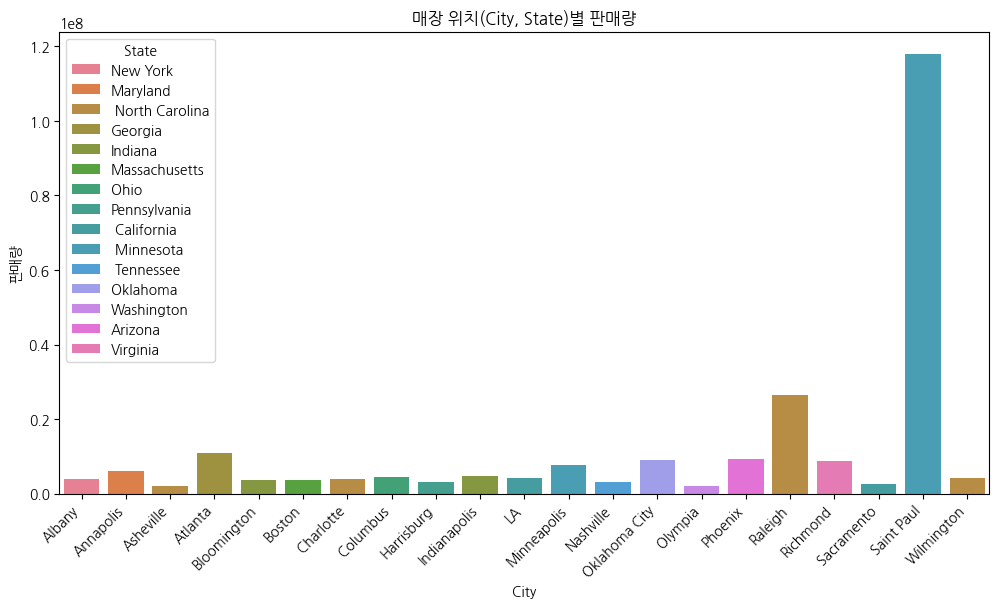

In [22]:
## 지역별 매출 분석

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

# 매장 위치(City, State)별 판매량 분석
location_sales = product_12.groupby(['City', 'State'])['Qty'].sum().reset_index()

# 시각화를 통해 매장 위치별 판매량 비교
plt.figure(figsize=(12, 6))
sns.barplot(x='City', y='Qty', hue='State', data=location_sales)
plt.title('매장 위치(City, State)별 판매량')
plt.xlabel('City')
plt.ylabel('판매량')
plt.xticks(rotation=45, ha='right')
plt.show()


           Date  Store_ID      Qty Day_Type  DayType_Sales
591  2014-01-02        44   9647.0  Weekday    7385.727273
1297 2014-01-03        44   8879.0  Weekday    7385.727273
2003 2014-01-04        44  14188.0  Weekend   11992.250000
2709 2014-01-05        44  14490.0  Weekend   11992.250000
3415 2014-01-06        44   7614.0  Weekday    7385.727273


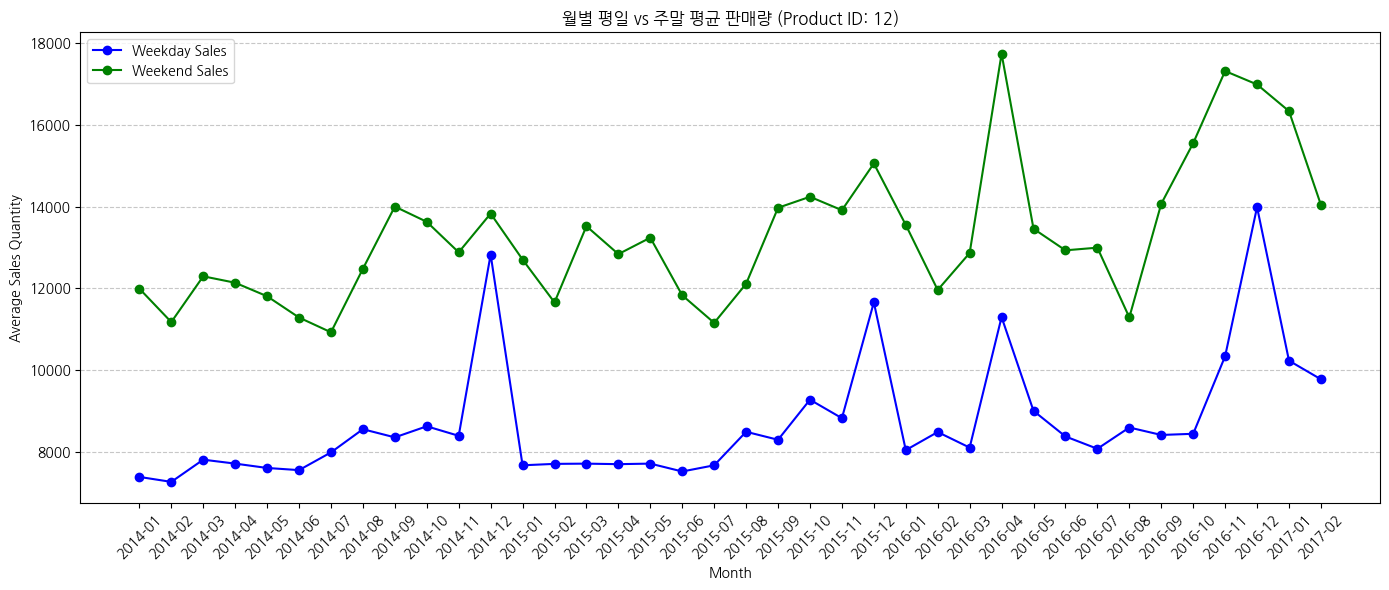

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Store_ID 44, Product_ID 12 필터링
store_id = 44
product_ids = [12]  # 상품 번호 리스트

df_filtered = df[(df['Store_ID'] == store_id) & (df['Product_ID'].isin(product_ids))]

# 날짜 형식을 datetime으로 변환
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# 요일 및 평일/주말 구분 추가
df_filtered['Weekday'] = df_filtered['Date'].dt.day_name()
df_filtered['Day_Type'] = df_filtered['Weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# 월별 평일 판매량 집계
weekday_sales = df_filtered[df_filtered['Day_Type'] == 'Weekday'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekday_sales.columns = ['Month', 'Weekday_Sales']
weekday_sales['Month'] = weekday_sales['Month'].astype(str)  # 문자열로 변환

# 월별 주말 판매량 집계
weekend_sales = df_filtered[df_filtered['Day_Type'] == 'Weekend'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekend_sales.columns = ['Month', 'Weekend_Sales']
weekend_sales['Month'] = weekend_sales['Month'].astype(str)  # 문자열로 변환

# 병합하여 하나의 데이터프레임으로 만들기 (월별 평일/주말 판매량)
monthly_sales = pd.merge(weekday_sales, weekend_sales, on='Month', how='outer').fillna(0)

# 'Month' 열을 문자열로 변환하여 병합 준비
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# DayType_Sales 열 추가
df_filtered['DayType_Sales'] = df_filtered.apply(
    lambda row: monthly_sales[monthly_sales['Month'] == row['Month']]['Weekday_Sales'].values[0]
    if row['Day_Type'] == 'Weekday'
    else monthly_sales[monthly_sales['Month'] == row['Month']]['Weekend_Sales'].values[0],
    axis=1
)

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales']].head())

# 월별 평일/주말 판매량 그래프 시각화 (선택 사항)
plt.figure(figsize=(14, 6))

# 평일 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekday_Sales'], label='Weekday Sales', marker='o', color='blue')

# 주말 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekend_Sales'], label='Weekend Sales', marker='o', color='green')

plt.title('월별 평일 vs 주말 평균 판매량 (Product ID: 12)')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales
591,2014-01-02,44,4422,9647.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7385.727273
1297,2014-01-03,44,4167,8879.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7385.727273
2003,2014-01-04,44,5341,14188.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,11992.250000
2709,2014-01-05,44,5123,14490.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,11992.250000
3415,2014-01-06,44,3917,7614.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7385.727273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861187,2017-02-24,44,4549,10630.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,9774.000000
861983,2017-02-25,44,4619,12978.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14041.125000
862779,2017-02-26,44,3877,10899.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14041.125000
863575,2017-02-27,44,3961,10618.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,9774.000000


In [25]:
import pandas as pd

# 월별 평균 판매량 계산
monthly_avg_sales = df_filtered.groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
monthly_avg_sales.columns = ['Month', 'Monthly_Sales']
monthly_avg_sales['Month'] = monthly_avg_sales['Month'].astype(str)

# df_filtered에 'Month' 열 추가 (이미 있다면 이 단계는 생략 가능)
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# df_filtered에 Monthly_Sales 열 추가
df_filtered = pd.merge(df_filtered, monthly_avg_sales, on='Month', how='left')

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales', 'Monthly_Sales']].head())

        Date  Store_ID      Qty Day_Type  DayType_Sales  Monthly_Sales
0 2014-01-02        44   9647.0  Weekday    7385.727273    8614.133333
1 2014-01-03        44   8879.0  Weekday    7385.727273    8614.133333
2 2014-01-04        44  14188.0  Weekend   11992.250000    8614.133333
3 2014-01-05        44  14490.0  Weekend   11992.250000    8614.133333
4 2014-01-06        44   7614.0  Weekday    7385.727273    8614.133333


In [26]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,9647.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7385.727273,8614.133333
1,2014-01-03,44,4167,8879.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7385.727273,8614.133333
2,2014-01-04,44,5341,14188.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,11992.250000,8614.133333
3,2014-01-05,44,5123,14490.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,11992.250000,8614.133333
4,2014-01-06,44,3917,7614.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7385.727273,8614.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10630.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,9774.000000,10993.178571
1142,2017-02-25,44,4619,12978.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14041.125000,10993.178571
1143,2017-02-26,44,3877,10899.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14041.125000,10993.178571
1144,2017-02-27,44,3961,10618.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,9774.000000,10993.178571


## **(3) 상품 : 42 - Agricultural products**

In [115]:
product_42 = pd.read_csv(path + 'product_42_data.csv')

In [116]:
product_42.head()

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type
0,2014-01-02,44,4422,76.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1
1,2014-01-03,44,4167,74.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1
2,2014-01-04,44,5341,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1
3,2014-01-05,44,5123,88.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1
4,2014-01-06,44,3917,65.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1


           Date  Store_ID   Qty Day_Type  DayType_Sales
598  2014-01-02        44  76.0  Weekday      70.681818
1304 2014-01-03        44  74.0  Weekday      70.681818
2010 2014-01-04        44  78.0  Weekend      80.625000
2716 2014-01-05        44  88.0  Weekend      80.625000
3422 2014-01-06        44  65.0  Weekday      70.681818


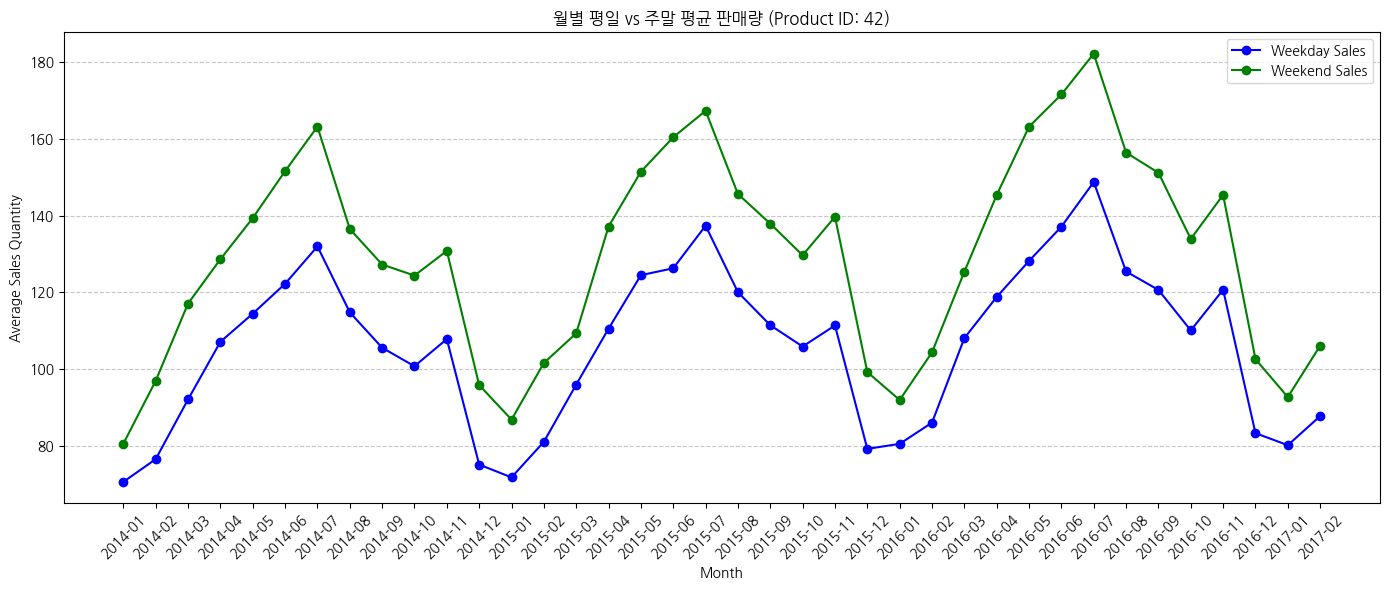

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Store_ID 44, Product_ID 42 필터링
store_id = 44
product_ids = [42]  # 상품 번호 리스트

df_filtered = df[(df['Store_ID'] == store_id) & (df['Product_ID'].isin(product_ids))]

# 날짜 형식을 datetime으로 변환
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])

# 요일 및 평일/주말 구분 추가
df_filtered['Weekday'] = df_filtered['Date'].dt.day_name()
df_filtered['Day_Type'] = df_filtered['Weekday'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# 월별 평일 판매량 집계
weekday_sales = df_filtered[df_filtered['Day_Type'] == 'Weekday'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekday_sales.columns = ['Month', 'Weekday_Sales']
weekday_sales['Month'] = weekday_sales['Month'].astype(str)  # 문자열로 변환

# 월별 주말 판매량 집계
weekend_sales = df_filtered[df_filtered['Day_Type'] == 'Weekend'].groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
weekend_sales.columns = ['Month', 'Weekend_Sales']
weekend_sales['Month'] = weekend_sales['Month'].astype(str)  # 문자열로 변환

# 병합하여 하나의 데이터프레임으로 만들기 (월별 평일/주말 판매량)
monthly_sales = pd.merge(weekday_sales, weekend_sales, on='Month', how='outer').fillna(0)

# 'Month' 열을 문자열로 변환하여 병합 준비
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# DayType_Sales 열 추가
df_filtered['DayType_Sales'] = df_filtered.apply(
    lambda row: monthly_sales[monthly_sales['Month'] == row['Month']]['Weekday_Sales'].values[0]
    if row['Day_Type'] == 'Weekday'
    else monthly_sales[monthly_sales['Month'] == row['Month']]['Weekend_Sales'].values[0],
    axis=1
)

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales']].head())

# 월별 평일/주말 판매량 그래프 시각화 (선택 사항)
plt.figure(figsize=(14, 6))

# 평일 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekday_Sales'], label='Weekday Sales', marker='o', color='blue')

# 주말 판매량 그래프
plt.plot(monthly_sales['Month'], monthly_sales['Weekend_Sales'], label='Weekend Sales', marker='o', color='green')

plt.title('월별 평일 vs 주말 평균 판매량 (Product ID: 42)')
plt.xlabel('Month')
plt.ylabel('Average Sales Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
import pandas as pd

# 월별 평균 판매량 계산
monthly_avg_sales = df_filtered.groupby(df_filtered['Date'].dt.to_period('M'))['Qty'].mean().reset_index()
monthly_avg_sales.columns = ['Month', 'Monthly_Sales']
monthly_avg_sales['Month'] = monthly_avg_sales['Month'].astype(str)

# df_filtered에 'Month' 열 추가 (이미 있다면 이 단계는 생략 가능)
df_filtered['Month'] = df_filtered['Date'].dt.to_period('M').astype(str)

# df_filtered에 Monthly_Sales 열 추가
df_filtered = pd.merge(df_filtered, monthly_avg_sales, on='Month', how='left')

# 결과 확인
print(df_filtered[['Date', 'Store_ID', 'Qty', 'Day_Type', 'DayType_Sales', 'Monthly_Sales']].head())

        Date  Store_ID   Qty Day_Type  DayType_Sales  Monthly_Sales
0 2014-01-02        44  76.0  Weekday      70.681818      73.333333
1 2014-01-03        44  74.0  Weekday      70.681818      73.333333
2 2014-01-04        44  78.0  Weekend      80.625000      73.333333
3 2014-01-05        44  88.0  Weekend      80.625000      73.333333
4 2014-01-06        44  65.0  Weekday      70.681818      73.333333


In [119]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,76.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,70.681818,73.333333
1,2014-01-03,44,4167,74.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,70.681818,73.333333
2,2014-01-04,44,5341,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,80.625000,73.333333
3,2014-01-05,44,5123,88.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,80.625000,73.333333
4,2014-01-06,44,3917,65.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,70.681818,73.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,91.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,87.800000,93.035714
1142,2017-02-25,44,4619,105.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,106.125000,93.035714
1143,2017-02-26,44,3877,108.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,106.125000,93.035714
1144,2017-02-27,44,3961,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,87.800000,93.035714


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [56]:
df_learn_merged = df_filtered

In [57]:
df_learn_merged

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,9853.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7109.454545,8807.200000
1,2014-01-03,44,4167,8647.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7109.454545,8807.200000
2,2014-01-04,44,5341,15153.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,13476.000000,8807.200000
3,2014-01-05,44,5123,15606.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,13476.000000,8807.200000
4,2014-01-06,44,3917,7900.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7109.454545,8807.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10208.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,8994.050000,10487.607143
1142,2017-02-25,44,4619,12361.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14221.500000,10487.607143
1143,2017-02-26,44,3877,10108.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14221.500000,10487.607143
1144,2017-02-27,44,3961,10006.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,8994.050000,10487.607143


In [58]:
df_learn_merged['target'] = df_learn_merged['Qty'].shift(-2)
df_learn_merged.drop(columns=['LeadTime'], axis=1, inplace=True)
df_learn_merged = df_learn_merged.reset_index(drop=True)
df_learn_merged

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales,target
0,2014-01-02,44,4422,9853.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7109.454545,8807.200000,15153.0
1,2014-01-03,44,4167,8647.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7109.454545,8807.200000,15606.0
2,2014-01-04,44,5341,15153.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,13476.000000,8807.200000,7900.0
3,2014-01-05,44,5123,15606.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,13476.000000,8807.200000,7188.0
4,2014-01-06,44,3917,7900.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7109.454545,8807.200000,8800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10208.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,8994.050000,10487.607143,10108.0
1142,2017-02-25,44,4619,12361.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14221.500000,10487.607143,10006.0
1143,2017-02-26,44,3877,10108.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14221.500000,10487.607143,14374.0
1144,2017-02-27,44,3961,10006.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,8994.050000,10487.607143,NaN


In [59]:
# 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
df_learn_merged.loc[df_learn_merged['Qty'] == 0.0, 'CustomerCount'] = 0.0

df_learn_merged['CustomerCount'] = df_learn_merged['CustomerCount'].interpolate(method='linear')

df_learn_merged.dropna(axis=0, inplace=True)

In [60]:
df_learn_merged

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales,target
0,2014-01-02,44,4422,9853.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7109.454545,8807.200000,15153.0
1,2014-01-03,44,4167,8647.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7109.454545,8807.200000,15606.0
2,2014-01-04,44,5341,15153.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,13476.000000,8807.200000,7900.0
3,2014-01-05,44,5123,15606.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,13476.000000,8807.200000,7188.0
4,2014-01-06,44,3917,7900.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7109.454545,8807.200000,8800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,44,3834,7856.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Wednesday,Weekday,2017-02,8994.050000,10487.607143,10208.0
1140,2017-02-23,44,3955,8018.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Thursday,Weekday,2017-02,8994.050000,10487.607143,12361.0
1141,2017-02-24,44,4549,10208.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,8994.050000,10487.607143,10108.0
1142,2017-02-25,44,4619,12361.0,3,DB001,Beverage,Drink,8,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14221.500000,10487.607143,10006.0


In [61]:
drop_cols = ['Store_ID','Product_ID','Product_Code','SubCategory','Category','City','State','Store_Type','Weekday','Day_Type','Month']
df_learn_merged.drop(drop_cols, axis=1, inplace=True)

In [101]:
df_learn_merged

,Date,CustomerCount,Qty,DayType_Sales,target
0,2014-01-02,4422,76.0,70.681818,78.0
1,2014-01-03,4167,74.0,70.681818,88.0
2,2014-01-04,5341,78.0,80.625000,65.0
3,2014-01-05,5123,88.0,80.625000,78.0
4,2014-01-06,3917,65.0,70.681818,73.0
...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,91.0
1140,2017-02-23,3955,98.0,87.800000,105.0
1141,2017-02-24,4549,91.0,87.800000,108.0
1142,2017-02-25,4619,105.0,106.125000,78.0


In [63]:
df_learn_merged.drop(columns=['Price'], axis=1, inplace=True)

In [64]:
df_learn_merged

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target
0,2014-01-02,4422,9853.0,7109.454545,8807.200000,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.200000,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.200000,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.200000,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.200000,8800.0
...,...,...,...,...,...,...
1139,2017-02-22,3834,7856.0,8994.050000,10487.607143,10208.0
1140,2017-02-23,3955,8018.0,8994.050000,10487.607143,12361.0
1141,2017-02-24,4549,10208.0,8994.050000,10487.607143,10108.0
1142,2017-02-25,4619,12361.0,14221.500000,10487.607143,10006.0


### **2) 모델링**

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [27]:
df_learn_merged = df_filtered

In [28]:
df_learn_merged

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,9647.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7385.727273,8614.133333
1,2014-01-03,44,4167,8879.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7385.727273,8614.133333
2,2014-01-04,44,5341,14188.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,11992.250000,8614.133333
3,2014-01-05,44,5123,14490.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,11992.250000,8614.133333
4,2014-01-06,44,3917,7614.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7385.727273,8614.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10630.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,9774.000000,10993.178571
1142,2017-02-25,44,4619,12978.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14041.125000,10993.178571
1143,2017-02-26,44,3877,10899.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14041.125000,10993.178571
1144,2017-02-27,44,3961,10618.0,12,GA001,Milk,Food,2,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,9774.000000,10993.178571


In [29]:
df_learn_merged['target'] = df_learn_merged['Qty'].shift(-2)
df_learn_merged.drop(columns=['LeadTime'], axis=1, inplace=True)
df_learn_merged = df_learn_merged.reset_index(drop=True)
df_learn_merged

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales,target
0,2014-01-02,44,4422,9647.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,7385.727273,8614.133333,14188.0
1,2014-01-03,44,4167,8879.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,7385.727273,8614.133333,14490.0
2,2014-01-04,44,5341,14188.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,11992.250000,8614.133333,7614.0
3,2014-01-05,44,5123,14490.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,11992.250000,8614.133333,7124.0
4,2014-01-06,44,3917,7614.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,7385.727273,8614.133333,8683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,10630.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,9774.000000,10993.178571,10899.0
1142,2017-02-25,44,4619,12978.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,14041.125000,10993.178571,10618.0
1143,2017-02-26,44,3877,10899.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,14041.125000,10993.178571,14400.0
1144,2017-02-27,44,3961,10618.0,12,GA001,Milk,Food,6,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,9774.000000,10993.178571,NaN


In [30]:
# 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
df_learn_merged.loc[df_learn_merged['Qty'] == 0.0, 'CustomerCount'] = 0.0

df_learn_merged['CustomerCount'] = df_learn_merged['CustomerCount'].interpolate(method='linear')

df_learn_merged.dropna(axis=0, inplace=True)

In [114]:
df_learn_merged

,Date,CustomerCount,Qty,DayType_Sales,target
0,2014-01-02,4422,76.0,70.681818,78.0
1,2014-01-03,4167,74.0,70.681818,88.0
2,2014-01-04,5341,78.0,80.625000,65.0
3,2014-01-05,5123,88.0,80.625000,78.0
4,2014-01-06,3917,65.0,70.681818,73.0
...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,91.0
1140,2017-02-23,3955,98.0,87.800000,105.0
1141,2017-02-24,4549,91.0,87.800000,108.0
1142,2017-02-25,4619,105.0,106.125000,78.0


In [32]:
drop_cols = ['Store_ID','Product_ID','Product_Code','SubCategory','Category','City','State','Store_Type','Weekday','Day_Type','Month']
df_learn_merged.drop(drop_cols, axis=1, inplace=True)

In [33]:
df_learn_merged

,Date,CustomerCount,Qty,Price,DayType_Sales,Monthly_Sales,target
0,2014-01-02,4422,9647.0,6,7385.727273,8614.133333,14188.0
1,2014-01-03,4167,8879.0,6,7385.727273,8614.133333,14490.0
2,2014-01-04,5341,14188.0,6,11992.250000,8614.133333,7614.0
3,2014-01-05,5123,14490.0,6,11992.250000,8614.133333,7124.0
4,2014-01-06,3917,7614.0,6,7385.727273,8614.133333,8683.0
...,...,...,...,...,...,...,...
1139,2017-02-22,3834,8931.0,6,9774.000000,10993.178571,10630.0
1140,2017-02-23,3955,8643.0,6,9774.000000,10993.178571,12978.0
1141,2017-02-24,4549,10630.0,6,9774.000000,10993.178571,10899.0
1142,2017-02-25,4619,12978.0,6,14041.125000,10993.178571,10618.0


In [34]:
df_learn_merged.drop(columns=['Price'], axis=1, inplace=True)

In [35]:
target = 'target'

x = df_learn_merged.drop([target, 'Date'], axis =1)
y = df_learn_merged.loc[:, target]


x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=60, shuffle=False)

scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s = scaler_y.transform(y_val.values.reshape(-1,1))

### **2) 모델링**

In [36]:
nfeatures = x_train_s.shape[1]

clear_session()

model = Sequential()
model.add(Dense(1, input_shape = (nfeatures,), activation = 'relu'))

model.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5 (20.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(x_train_s, y_train_s, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2677 - mae: 0.3978 - mape: 1052141.5000 - val_loss: 0.3738 - val_mae: 0.4742 - val_mape: 318.9222
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2356 - mae: 0.3673 - mape: 1325727.8750 - val_loss: 0.3111 - val_mae: 0.4211 - val_mape: 283.5060
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1944 - mae: 0.3316 - mape: 560266.5000 - val_loss: 0.2593 - val_mae: 0.3759 - val_mape: 252.2877
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1569 - mae: 0.2868 - mape: 1019851.3125 - val_loss: 0.2156 - val_mae: 0.3363 - val_mape: 223.8020
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1256 - mae: 0.2494 - mape: 1551053.1250 - val_loss: 0.1810 - val_mae: 0.3042 - val_mape: 199.5470
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1110 - mae: 0.2439 - mape: 204088.2344 - val_loss: 0.1530 - val_mae: 0.2773 - val_mape: 178.5803
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - l

In [38]:
pred = model.predict(x_val_s)

# 예측 결과 원래 스케일로
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)
print()
# 평가
rmse = mean_squared_error(y_val, pred, squared=False)
mae = mean_absolute_error(y_val, pred)
mape = mean_absolute_percentage_error(y_val, pred)
r2 = r2_score(y_val, pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



In [39]:
pred

array([11945.447 , 10962.545 , 14946.359 , 15839.578 , 11647.128 ,
        6898.221 ,  6635.2437,  4971.484 ,  7215.4863, 17130.646 ,
       16648.137 ,  4940.6147,  4390.    ,  5582.7524,  4390.    ,
        5631.479 , 15493.647 , 16479.826 ,  4964.8647,  4390.    ,
        4887.7627,  4390.    ,  4551.101 , 16265.838 , 15919.174 ,
        4409.9253,  4390.    ,  4390.    ,  4390.    ,  5061.9766,
       14880.994 , 14617.329 ,  4390.    ,  4390.    ,  5996.537 ,
        4390.    ,  5078.087 , 12790.666 , 13426.462 ,  4390.    ,
        4390.    ,  4995.754 ,  4390.    ,  4869.2334, 10933.083 ,
       11726.832 ,  4562.6963,  4390.    ,  4390.    ,  4390.    ,
        4729.6514, 13396.371 ,  9268.123 ,  4390.    ,  4390.    ,
        4390.    ,  4390.    ,  4749.0776, 10590.477 ,  8706.962 ],
      dtype=float32)

In [40]:
print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

┌─────────┬────────────────┐
│ Metric  │         Value  │
├─────────┼────────────────┤
│ RMSE    │      7000.7781 │
├─────────┼────────────────┤
│ MAE     │      6244.1140 │
├─────────┼────────────────┤
│ MAPE    │       53.9924% │
├─────────┼────────────────┤
│ R2      │        -3.7725 │
└─────────┴────────────────┘


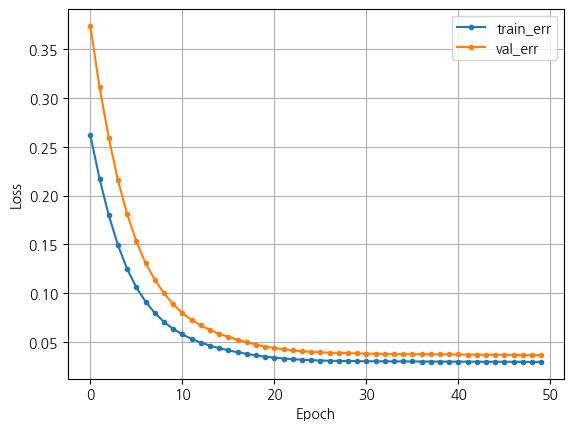

In [41]:
dl_history_plot(history)

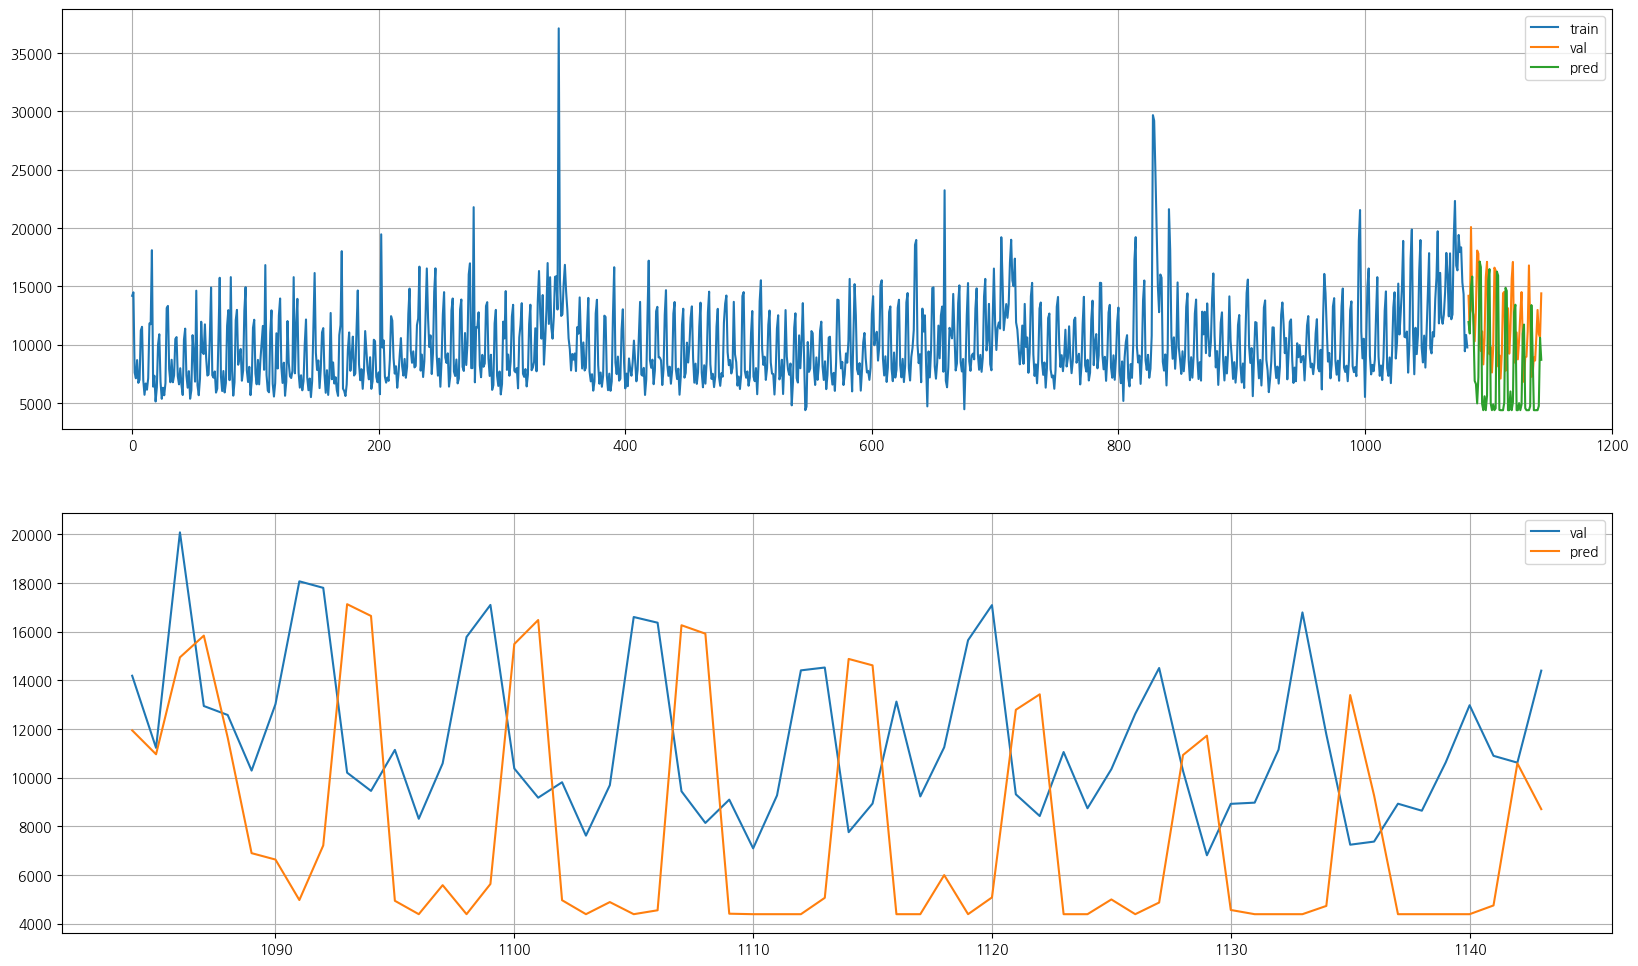

In [42]:
plot_model_result(y_train, y_val, pred)

## 공휴일 넣은 베이스라인

In [120]:
df_learn_merged

,Date,CustomerCount,Qty,DayType_Sales,target
0,2014-01-02,4422,76.0,70.681818,78.0
1,2014-01-03,4167,74.0,70.681818,88.0
2,2014-01-04,5341,78.0,80.625000,65.0
3,2014-01-05,5123,88.0,80.625000,78.0
4,2014-01-06,3917,65.0,70.681818,73.0
...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,91.0
1140,2017-02-23,3955,98.0,87.800000,105.0
1141,2017-02-24,4549,91.0,87.800000,108.0
1142,2017-02-25,4619,105.0,106.125000,78.0


In [100]:
df_learn_merged2 = df_learn_merged.copy()
df_learn_merged2

,Date,CustomerCount,Qty,DayType_Sales,target
0,2014-01-02,4422,76.0,70.681818,78.0
1,2014-01-03,4167,74.0,70.681818,88.0
2,2014-01-04,5341,78.0,80.625000,65.0
3,2014-01-05,5123,88.0,80.625000,78.0
4,2014-01-06,3917,65.0,70.681818,73.0
...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,91.0
1140,2017-02-23,3955,98.0,87.800000,105.0
1141,2017-02-24,4549,91.0,87.800000,108.0
1142,2017-02-25,4619,105.0,106.125000,78.0


In [97]:
import pandas as pd
from datetime import timedelta

# 공휴일 리스트 (월-일 형식)
holiday_dates = [
    "01-01",  # New Year's Day
    "01-16",  # Martin Luther King Jr. Day
    "02-20",  # Presidents' Day
    "05-29",  # Memorial Day
    "06-19",  # Juneteenth
    "07-04",  # Independence Day
    "09-04",  # Labor Day
    "10-09",  # Columbus Day
    "11-11",  # Veterans Day
    "11-23",  # Thanksgiving
    "12-25"   # Christmas
]

# 공휴일 여부를 판단하는 함수 (당일)
def is_holiday(date):
    return "Yes" if date.strftime("%m-%d") in holiday_dates else "No"

# 공휴일 리스트에서 전날과 전전날 날짜 생성
day_before_holidays = []
two_days_before_holidays = []

for year in range(2014, 2018):  # 연도 범위 설정 (필요에 따라 조정 가능)
    for hd in holiday_dates:
        holiday_date = pd.to_datetime(f"{year}-{hd}")
        day_before_holidays.append((holiday_date - timedelta(days=1)).strftime("%Y-%m-%d"))
        two_days_before_holidays.append((holiday_date - timedelta(days=2)).strftime("%Y-%m-%d"))

# Date 열을 datetime 형식으로 변환 (이미 변환되어 있으면 생략 가능)
df_learn_merged2['Date'] = pd.to_datetime(df_learn_merged2['Date'])

# 공휴일 여부 추가 (당일)
df_learn_merged2['H_D'] = df_learn_merged2['Date'].apply(is_holiday)

# Date 열을 문자열로 변환하여 비교 (필요 시)
df_learn_merged2['Date_str'] = df_learn_merged2['Date'].dt.strftime("%Y-%m-%d")

# 공휴일 전날 여부 추가
df_learn_merged2['H_D_1'] = df_learn_merged2['Date_str'].isin(day_before_holidays).map({True: "Yes", False: "No"})

# 공휴일 전전날 여부 추가
df_learn_merged2['H_D_2'] = df_learn_merged2['Date_str'].isin(two_days_before_holidays).map({True: "Yes", False: "No"})

# 불필요한 열 삭제 (Date_str은 더 이상 필요 없으므로 삭제)
df_learn_merged2.drop(columns=['Date_str'], inplace=True)

In [75]:
df_learn_merged2.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target,H_D,H_D_1,H_D_2
0,2014-01-02,4422,9853.0,7109.454545,8807.2,15153.0,No,No,No
1,2014-01-03,4167,8647.0,7109.454545,8807.2,15606.0,No,No,No
2,2014-01-04,5341,15153.0,13476.000000,8807.2,7900.0,No,No,No
3,2014-01-05,5123,15606.0,13476.000000,8807.2,7188.0,No,No,No
4,2014-01-06,3917,7900.0,7109.454545,8807.2,8800.0,No,No,No


In [76]:
# 기존 데이터프레임에서 'target'을 가장 오른쪽으로 이동
cols = df_learn_merged2.columns.tolist()  # 현재 컬럼 리스트를 가져옴
cols.remove('target')  # 'target' 컬럼을 리스트에서 제거
cols.append('target')  # 'target'을 리스트의 마지막에 추가

# 새롭게 재배치된 데이터프레임 생성
df_learn_merged2 = df_learn_merged2[cols]

# 결과 확인
df_learn_merged2.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target
0,2014-01-02,4422,9853.0,7109.454545,8807.2,No,No,No,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.2,No,No,No,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.2,No,No,No,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.2,No,No,No,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.2,No,No,No,8800.0


In [143]:
#df_learn_merged2.drop(columns=['Price'], axis=1, inplace=True)

In [144]:
x = df_learn_merged2.drop([target, 'Date'], axis =1)
y = df_learn_merged2[target]

x = pd.get_dummies(x, columns=['H_D', 'H_D_1', 'H_D_2'], drop_first=True, dtype='int')

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=False)

scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s = scaler_y.transform(y_val.values.reshape(-1,1))

In [145]:
x_train

,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D_Yes,H_D_1_Yes,H_D_2_Yes
0,4422,9647.0,7385.727273,8614.133333,0,0,0
1,4167,8879.0,7385.727273,8614.133333,0,0,0
2,5341,14188.0,11992.250000,8614.133333,0,0,0
3,5123,14490.0,11992.250000,8614.133333,0,0,0
4,3917,7614.0,7385.727273,8614.133333,0,0,0
...,...,...,...,...,...,...,...
910,4434,9712.0,8074.190476,9661.258065,0,0,0
911,3285,5591.0,8074.190476,9661.258065,0,0,0
912,4271,8960.0,8074.190476,9661.258065,0,0,0
913,4707,11941.0,12994.100000,9661.258065,0,0,0


In [146]:
nfeatures = x_train_s.shape[1]

clear_session()

model2 = Sequential()
model2.add(Dense(1, input_shape = (nfeatures,), activation = 'relu'))

model2.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8 (32.00 B)

 Trainable params: 8 (32.00 B)

 Non-trainable params: 0 (0.00 B)

In [147]:
history2 = model2.fit(x_train_s, y_train_s, epochs=50, validation_split=.2).history

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0215 - mae: 0.1053 - mape: 365088.9062 - val_loss: 0.0310 - val_mae: 0.1231 - val_mape: 89.0770
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - mae: 0.1094 - mape: 430885.0312 - val_loss: 0.0266 - val_mae: 0.1154 - val_mape: 80.3750
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mae: 0.1063 - mape: 29170.4902 - val_loss: 0.0249 - val_mae: 0.1124 - val_mape: 78.4905
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mae: 0.1031 - mape: 179629.8594 - val_loss: 0.0233 - val_mae: 0.1092 - val_mape: 76.3329
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - mae: 0.1020 - mape: 56844.6484 - val_loss: 0.0219 - val_mae: 0.1063 - val_mape: 74.5889
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - mae: 0.0943 - mape: 342480.6562 - val_loss: 0.0211 - val_mae: 0.1047 - val_mape: 74.7149
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 

In [148]:
pred2 = model2.predict(x_val_s)

# 예측 결과 원래 스케일로
pred2 = scaler_y.inverse_transform(pred2)
pred2 = pred2.reshape(-1,)

print()
# 평가
rmse = mean_squared_error(y_val, pred2, squared=False)
mae = mean_absolute_error(y_val, pred2)
mape = mean_absolute_percentage_error(y_val, pred2)
r2 = r2_score(y_val, pred2)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 



In [149]:
print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

┌─────────┬────────────────┐
│ Metric  │         Value  │
├─────────┼────────────────┤
│ RMSE    │      2895.4388 │
├─────────┼────────────────┤
│ MAE     │      2345.4408 │
├─────────┼────────────────┤
│ MAPE    │       21.7029% │
├─────────┼────────────────┤
│ R2      │         0.3276 │
└─────────┴────────────────┘


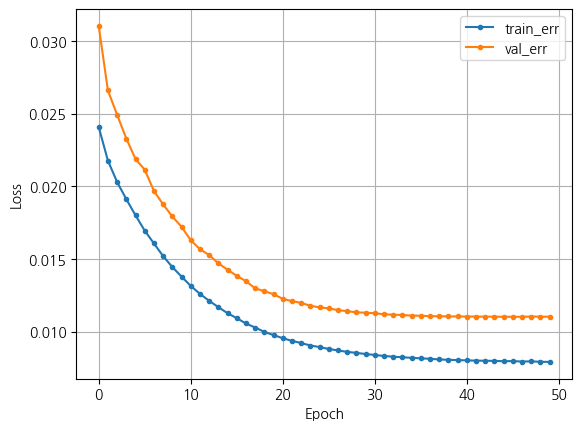

In [150]:
dl_history_plot(history2)

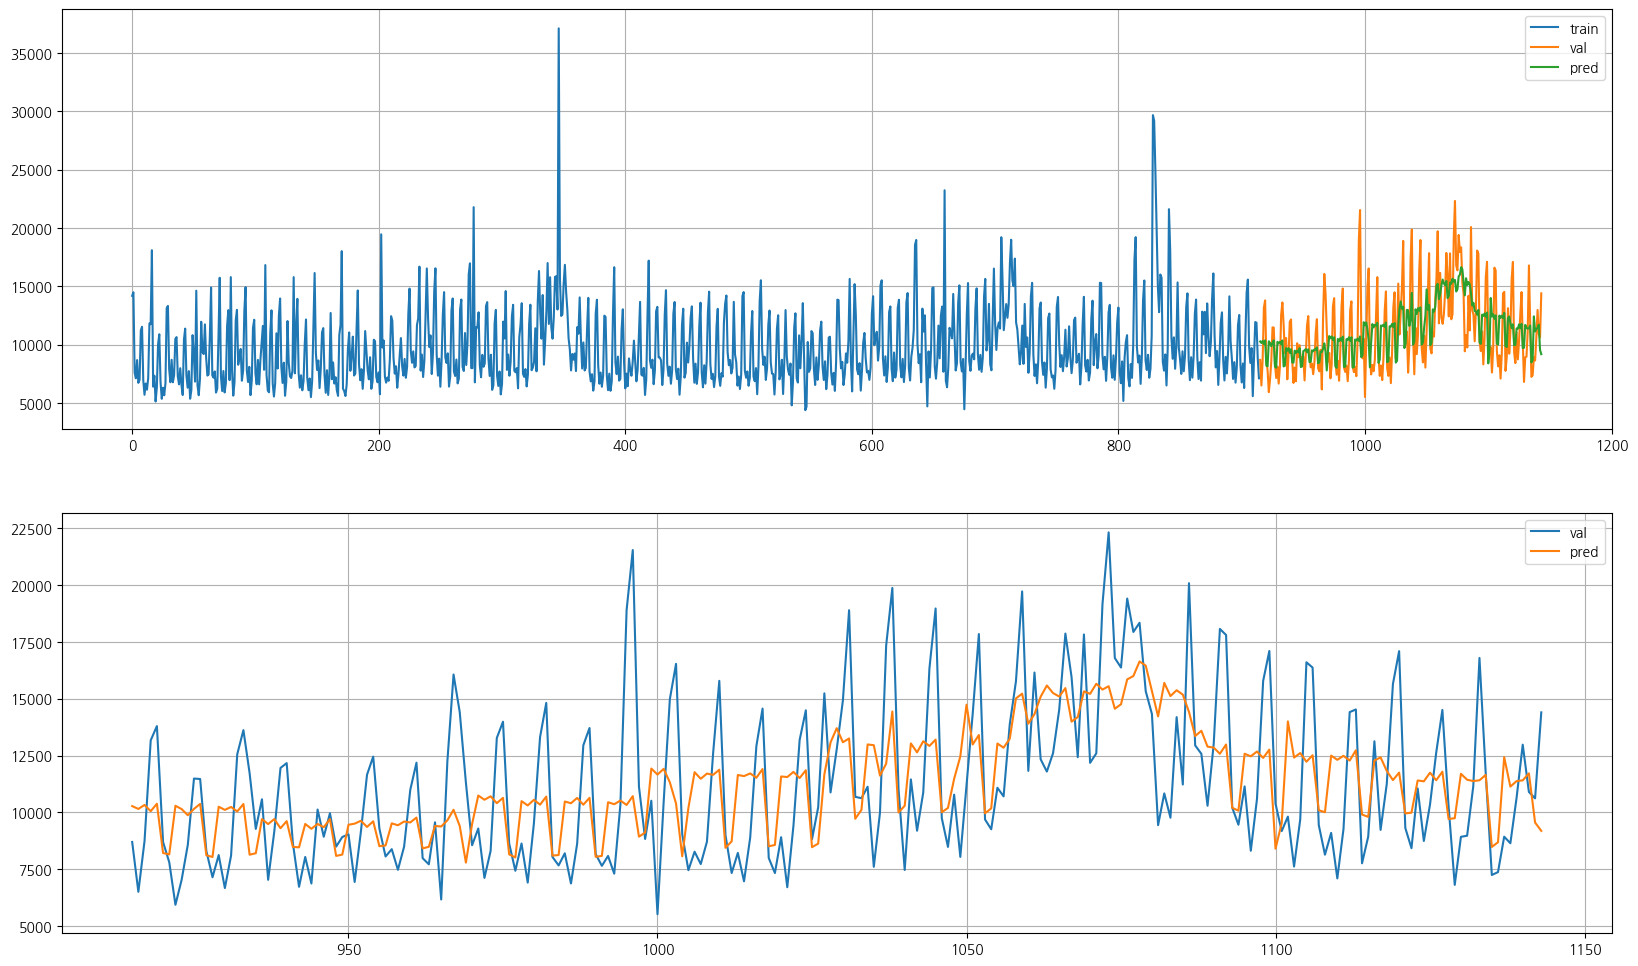

In [151]:
plot_model_result(y_train, y_val, pred2)

## 강사님 코드 돌려서 데이터셋 만든 거

In [77]:
def make_dataset(Product_ID):

    # 1. 기본 데이터 준비
    leadTime = products.loc[products['Product_ID']==Product_ID, 'LeadTime'].values[0]
    temp1 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==Product_ID), ['Date','Qty']]
    temp2 = orders.loc[orders['Store_ID']==44, ['Date','CustomerCount']]
    temp3 = pd.merge(temp1, temp2)
    temp3['target'] = temp3['Qty'].shift(-leadTime)
    temp3.dropna(inplace = True)

    # 2. feature engineering
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    return temp3


In [78]:
data3 = make_dataset(3)
data3.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount
0,2014-01-02,9853.0,4422,15153.0,Thursday,1,10142.0,45969
1,2014-01-03,8647.0,4167,15606.0,Friday,1,8980.0,42386
2,2014-01-04,15153.0,5341,7900.0,Saturday,1,15684.0,52293
3,2014-01-05,15606.0,5123,7188.0,Sunday,1,15606.0,49199
4,2014-01-06,7900.0,3917,8800.0,Monday,1,8083.0,39105


In [153]:
data12 = make_dataset(12)
data12.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount
0,2014-01-02,9647.0,4422,14188.0,Thursday,1,15195.550,45969
1,2014-01-03,8879.0,4167,14490.0,Friday,1,13952.689,42386
2,2014-01-04,14188.0,5341,7614.0,Saturday,1,22059.125,52293
3,2014-01-05,14490.0,5123,7124.0,Sunday,1,22443.851,49199
4,2014-01-06,7614.0,3917,8683.0,Monday,1,11853.281,39105


In [79]:
def preproc(data, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x = pd.get_dummies(x, columns = ['WeekDay','Month'])

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [47]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc(data12, True)
y_min, y_max

NameError: name 'data12' is not defined

In [156]:
clear_session()

nfeat = x_train.shape[1]

model12_00 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model12_00.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

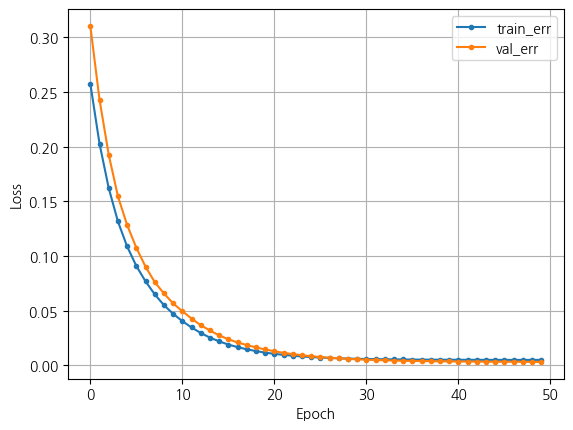

In [157]:
model12_00.compile(optimizer = 'adam', loss = 'mse')
hist = model12_00.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [158]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_00.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
MAE :  1851.444913736979
MAPE :  0.1550265431441513
R2 :  0.4647690484170788


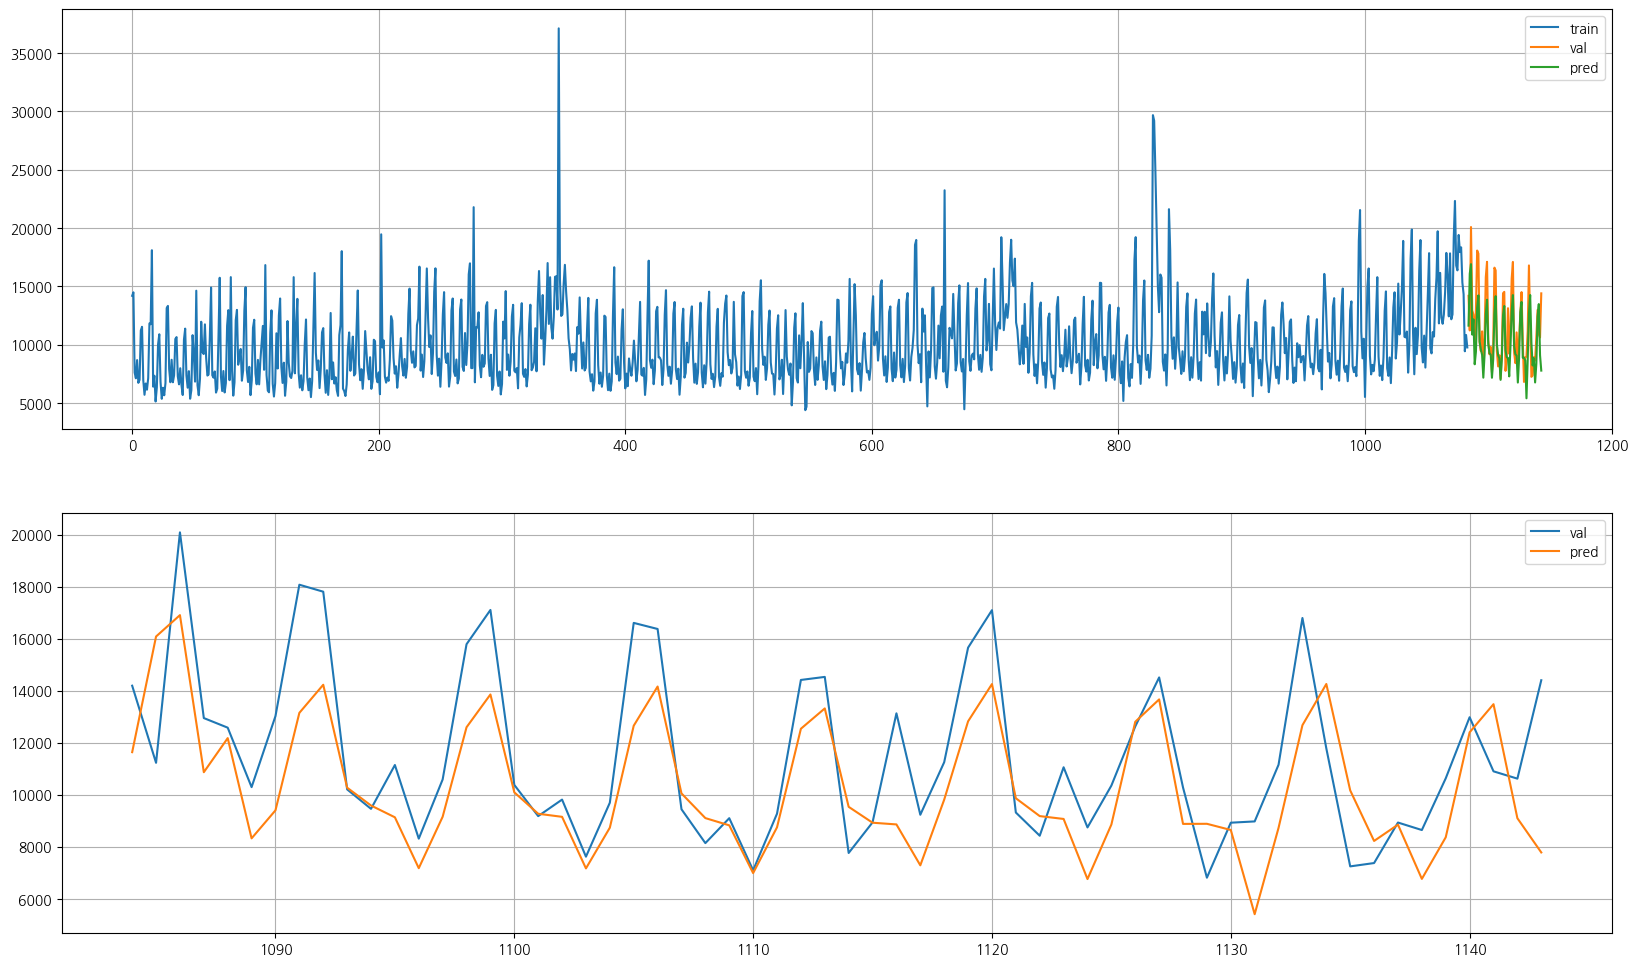

In [159]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## 위 코드 참고해서 오일 데이터 빼고 공휴일, 주말/평일 평균 판매량, 월 별 판매량 넣기

In [80]:
df_learn_merged2

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target
0,2014-01-02,4422,9853.0,7109.454545,8807.200000,No,No,No,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.200000,No,No,No,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.200000,No,No,No,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.200000,No,No,No,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.200000,No,No,No,8800.0
...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,7856.0,8994.050000,10487.607143,No,No,No,10208.0
1140,2017-02-23,3955,8018.0,8994.050000,10487.607143,No,No,No,12361.0
1141,2017-02-24,4549,10208.0,8994.050000,10487.607143,No,No,No,10108.0
1142,2017-02-25,4619,12361.0,14221.500000,10487.607143,No,No,No,10006.0


In [81]:
def make_dataset2(temp3,Product_ID):
    # 2.1 날짜 요소 추출
    temp3['WeekDay'] = temp3['Date'].dt.day_name()
    temp3['Month'] = temp3['Date'].dt.month

    # 2.2 동일 카테고리 판매량 합계
    Category = products.loc[products['Product_ID'].isin([Product_ID]), 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    temp4 = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID'].isin(Product_IDs))].groupby('Date', as_index = False)['Qty'].sum()
    temp4.columns = ['Date', 'Category_Qty']
    temp3 = pd.merge(temp3, temp4, how = 'left')

    # 2.3 동일 지역 방문객 수
    City = stores.loc[stores['Store_ID']==44, 'City'].values[0]
    Store_IDs = stores.loc[stores['City']==City, 'Store_ID'].to_list()
    temp5 = orders.loc[orders['Store_ID'].isin(Store_IDs)].groupby('Date', as_index = False)['CustomerCount'].sum()
    temp5.columns = ['Date', 'City_CustCount']
    temp3 = pd.merge(temp3, temp5, how = 'left')

    return temp3

In [82]:
df_learn_merged3 = df_learn_merged2.copy()

In [83]:
base_3 = make_dataset2(df_learn_merged3,3)
base_3

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target,WeekDay,Month,Category_Qty,City_CustCount
0,2014-01-02,4422,9853.0,7109.454545,8807.200000,No,No,No,15153.0,Thursday,1,10142.0,45969
1,2014-01-03,4167,8647.0,7109.454545,8807.200000,No,No,No,15606.0,Friday,1,8980.0,42386
2,2014-01-04,5341,15153.0,13476.000000,8807.200000,No,No,No,7900.0,Saturday,1,15684.0,52293
3,2014-01-05,5123,15606.0,13476.000000,8807.200000,No,No,No,7188.0,Sunday,1,15606.0,49199
4,2014-01-06,3917,7900.0,7109.454545,8807.200000,No,No,No,8800.0,Monday,1,8083.0,39105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,7856.0,8994.050000,10487.607143,No,No,No,10208.0,Wednesday,2,8118.0,38673
1140,2017-02-23,3955,8018.0,8994.050000,10487.607143,No,No,No,12361.0,Thursday,2,8316.0,39881
1141,2017-02-24,4549,10208.0,8994.050000,10487.607143,No,No,No,10108.0,Friday,2,10689.0,43170
1142,2017-02-25,4619,12361.0,14221.500000,10487.607143,No,No,No,10006.0,Saturday,2,13073.0,46801


In [163]:
base_12 = make_dataset2(df_learn_merged3,12)
base_12

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,target,WeekDay,Month,Category_Qty,City_CustCount
0,2014-01-02,4422,9647.0,7385.727273,8614.133333,No,No,No,14188.0,Thursday,1,15195.550,45969
1,2014-01-03,4167,8879.0,7385.727273,8614.133333,No,No,No,14490.0,Friday,1,13952.689,42386
2,2014-01-04,5341,14188.0,11992.250000,8614.133333,No,No,No,7614.0,Saturday,1,22059.125,52293
3,2014-01-05,5123,14490.0,11992.250000,8614.133333,No,No,No,7124.0,Sunday,1,22443.851,49199
4,2014-01-06,3917,7614.0,7385.727273,8614.133333,No,No,No,8683.0,Monday,1,11853.281,39105
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,8931.0,9774.000000,10993.178571,No,No,No,10630.0,Wednesday,2,13281.361,38673
1140,2017-02-23,3955,8643.0,9774.000000,10993.178571,No,No,No,12978.0,Thursday,2,12888.873,39881
1141,2017-02-24,4549,10630.0,9774.000000,10993.178571,No,No,No,10899.0,Friday,2,15817.968,43170
1142,2017-02-25,4619,12978.0,14041.125000,10993.178571,No,No,No,10618.0,Saturday,2,19393.951,46801


In [84]:
# 기존 데이터프레임에서 'target'을 가장 오른쪽으로 이동
cols = base_3.columns.tolist()  # 현재 컬럼 리스트를 가져옴
cols.remove('target')  # 'target' 컬럼을 리스트에서 제거
cols.append('target')  # 'target'을 리스트의 마지막에 추가

# 새롭게 재배치된 데이터프레임 생성
base_3 = base_3[cols]

# 결과 확인
base_3.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9853.0,7109.454545,8807.2,No,No,No,Thursday,1,10142.0,45969,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.2,No,No,No,Friday,1,8980.0,42386,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.2,No,No,No,Saturday,1,15684.0,52293,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.2,No,No,No,Sunday,1,15606.0,49199,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.2,No,No,No,Monday,1,8083.0,39105,8800.0


In [164]:
# 기존 데이터프레임에서 'target'을 가장 오른쪽으로 이동
cols = base_12.columns.tolist()  # 현재 컬럼 리스트를 가져옴
cols.remove('target')  # 'target' 컬럼을 리스트에서 제거
cols.append('target')  # 'target'을 리스트의 마지막에 추가

# 새롭게 재배치된 데이터프레임 생성
base_12 = base_12[cols]

# 결과 확인
base_12.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9647.0,7385.727273,8614.133333,No,No,No,Thursday,1,15195.550,45969,14188.0
1,2014-01-03,4167,8879.0,7385.727273,8614.133333,No,No,No,Friday,1,13952.689,42386,14490.0
2,2014-01-04,5341,14188.0,11992.250000,8614.133333,No,No,No,Saturday,1,22059.125,52293,7614.0
3,2014-01-05,5123,14490.0,11992.250000,8614.133333,No,No,No,Sunday,1,22443.851,49199,7124.0
4,2014-01-06,3917,7614.0,7385.727273,8614.133333,No,No,No,Monday,1,11853.281,39105,8683.0


In [85]:
def preproc2(data, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['H_D'] = pd.Categorical(x['H_D'], categories = ['Yes', 'No'])
    x['H_D_1'] = pd.Categorical(x['H_D_1'], categories = ['Yes', 'No'])
    x['H_D_2'] = pd.Categorical(x['H_D_2'], categories = ['Yes', 'No'])

    x = pd.get_dummies(x, columns = ['WeekDay','Month','H_D','H_D_1','H_D_2'])
    display(x)
    display(x.columns)
    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

In [166]:
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc2(base_12, True)
y_min, y_max

,CustomerCount,Qty,DayType_Sales,Monthly_Sales,Category_Qty,City_CustCount,WeekDay_Monday,WeekDay_Tuesday,WeekDay_Wednesday,WeekDay_Thursday,...,Month_9,Month_10,Month_11,Month_12,H_D_Yes,H_D_No,H_D_1_Yes,H_D_1_No,H_D_2_Yes,H_D_2_No
0,4422,9647.0,7385.727273,8614.133333,15195.550,45969,False,False,False,True,...,False,False,False,False,False,True,False,True,False,True
1,4167,8879.0,7385.727273,8614.133333,13952.689,42386,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
2,5341,14188.0,11992.250000,8614.133333,22059.125,52293,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
3,5123,14490.0,11992.250000,8614.133333,22443.851,49199,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
4,3917,7614.0,7385.727273,8614.133333,11853.281,39105,True,False,False,False,...,False,False,False,False,False,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,3834,8931.0,9774.000000,10993.178571,13281.361,38673,False,False,True,False,...,False,False,False,False,False,True,False,True,False,True
1140,3955,8643.0,9774.000000,10993.178571,12888.873,39881,False,False,False,True,...,False,False,False,False,False,True,False,True,False,True
1141,4549,10630.0,9774.000000,10993.178571,15817.968,43170,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
1142,4619,12978.0,14041.125000,10993.178571,19393.951,46801,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True


Index(['CustomerCount', 'Qty', 'DayType_Sales', 'Monthly_Sales',
       'Category_Qty', 'City_CustCount', 'WeekDay_Monday', 'WeekDay_Tuesday',
       'WeekDay_Wednesday', 'WeekDay_Thursday', 'WeekDay_Friday',
       'WeekDay_Saturday', 'WeekDay_Sunday', 'Month_1', 'Month_2', 'Month_3',
       'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9',
       'Month_10', 'Month_11', 'Month_12', 'H_D_Yes', 'H_D_No', 'H_D_1_Yes',
       'H_D_1_No', 'H_D_2_Yes', 'H_D_2_No'],
      dtype='object')

(4390.0, 37106.0)

In [167]:
clear_session()

nfeat = x_train.shape[1]

model12_01 = Sequential([Dense(1, input_shape = (nfeat, ) )])
model12_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32 (128.00 B)

 Trainable params: 32 (128.00 B)

 Non-trainable params: 0 (0.00 B)

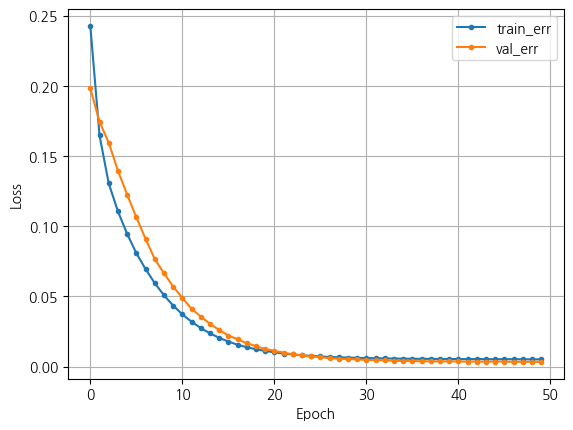

In [168]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [169]:
# 스케일링 된 데이터 돌려서 평가하기
pred3 = model12_01.predict(x_val)
pred3 = pred3 * (y_max - y_min) + y_min
y_val3 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val3, pred3))
print('MAPE : ',mean_absolute_percentage_error(y_val3, pred3))
print('R2 : ',r2_score(y_val3, pred3))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MAE :  1708.06982421875
MAPE :  0.1687225292961131
R2 :  0.527700913775845


In [170]:
rmse = mean_squared_error(y_val3, pred3, squared=False)
mae = mean_absolute_error(y_val3, pred3)
mape = mean_absolute_percentage_error(y_val3, pred3)
r2 = r2_score(y_val3, pred3)

print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

┌─────────┬────────────────┐
│ Metric  │         Value  │
├─────────┼────────────────┤
│ RMSE    │      2202.3341 │
├─────────┼────────────────┤
│ MAE     │      1708.0698 │
├─────────┼────────────────┤
│ MAPE    │       16.8723% │
├─────────┼────────────────┤
│ R2      │         0.5277 │
└─────────┴────────────────┘


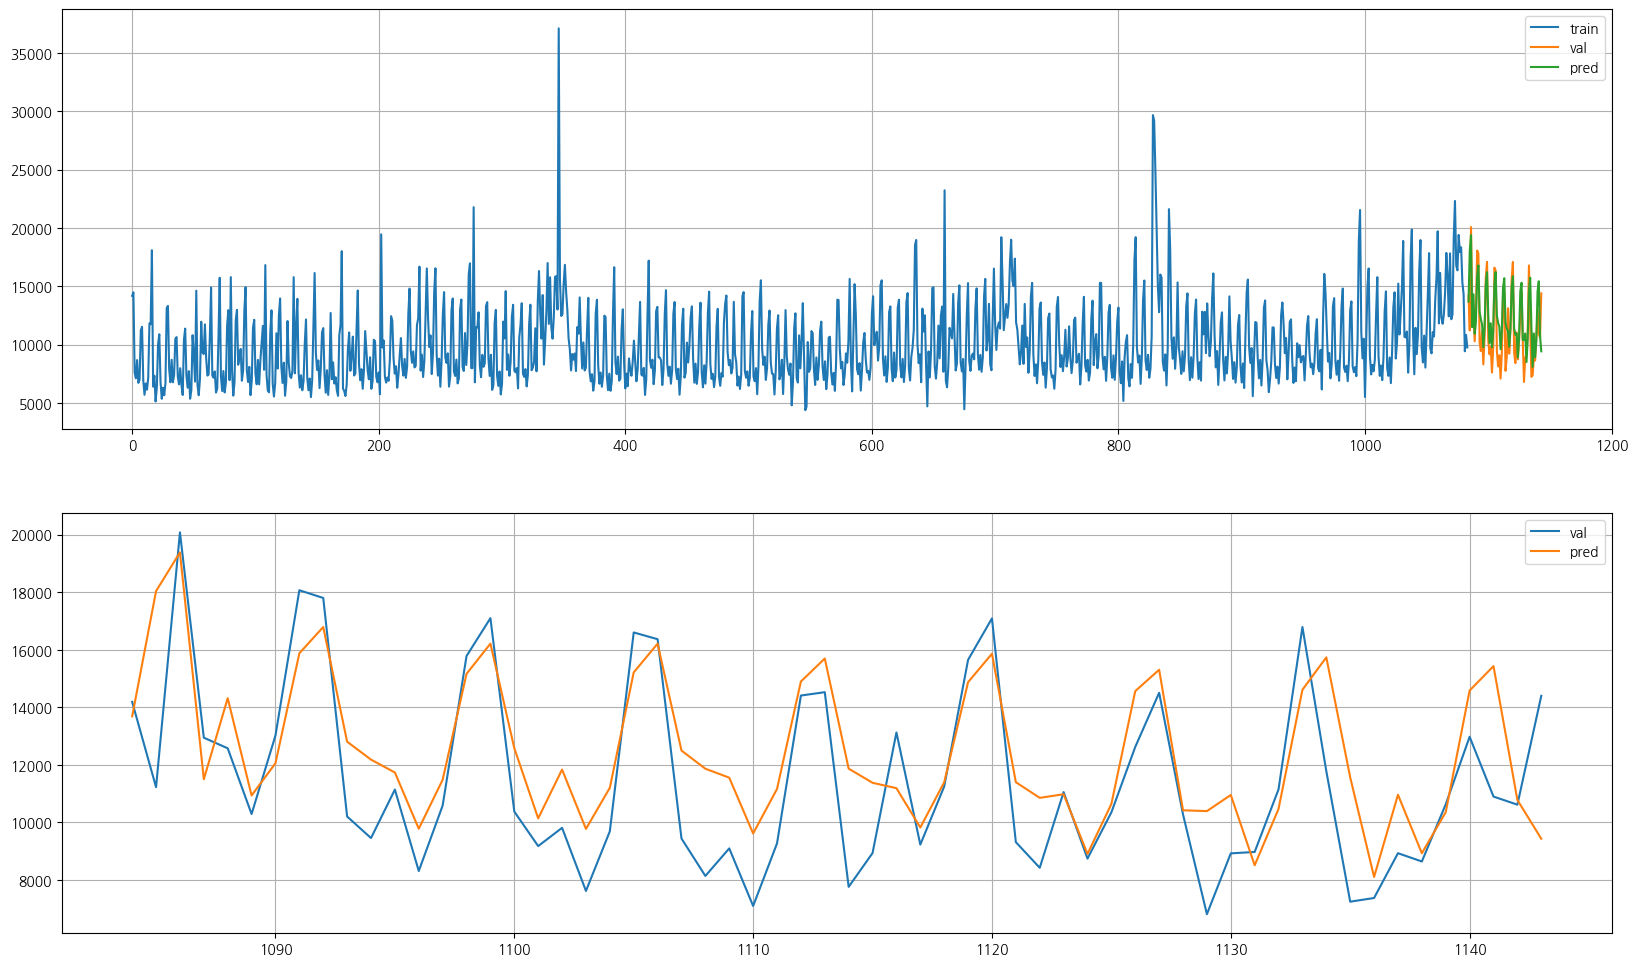

In [171]:
y_train3 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train3, y_val3, pred3)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [121]:
df_filtered

,Date,Store_ID,CustomerCount,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,Weekday,Day_Type,Month,DayType_Sales,Monthly_Sales
0,2014-01-02,44,4422,76.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Thursday,Weekday,2014-01,70.681818,73.333333
1,2014-01-03,44,4167,74.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Friday,Weekday,2014-01,70.681818,73.333333
2,2014-01-04,44,5341,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Saturday,Weekend,2014-01,80.625000,73.333333
3,2014-01-05,44,5123,88.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Sunday,Weekend,2014-01,80.625000,73.333333
4,2014-01-06,44,3917,65.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Monday,Weekday,2014-01,70.681818,73.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,2017-02-24,44,4549,91.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Friday,Weekday,2017-02,87.800000,93.035714
1142,2017-02-25,44,4619,105.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Saturday,Weekend,2017-02,106.125000,93.035714
1143,2017-02-26,44,3877,108.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Sunday,Weekend,2017-02,106.125000,93.035714
1144,2017-02-27,44,3961,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,Monday,Weekday,2017-02,87.800000,93.035714


In [122]:
df_learn_merged = df_filtered

df_learn_merged['target'] = df_learn_merged['Qty'].shift(-2)
df_learn_merged.drop(columns=['LeadTime'], axis=1, inplace=True)
df_learn_merged = df_learn_merged.reset_index(drop=True)

# 'Qty'가 0.0인 경우 'CustomerCount'를 0.0으로 설정
df_learn_merged.loc[df_learn_merged['Qty'] == 0.0, 'CustomerCount'] = 0.0

df_learn_merged['CustomerCount'] = df_learn_merged['CustomerCount'].interpolate(method='linear')

df_learn_merged.dropna(axis=0, inplace=True)

drop_cols = ['Store_ID','Product_ID','Product_Code','SubCategory','Category','City','State','Store_Type','Weekday','Day_Type','Month']
df_learn_merged.drop(drop_cols, axis=1, inplace=True)
df_learn_merged.drop(columns=['Price'], axis=1, inplace=True)

df_learn_merged

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target
0,2014-01-02,4422,76.0,70.681818,73.333333,78.0
1,2014-01-03,4167,74.0,70.681818,73.333333,88.0
2,2014-01-04,5341,78.0,80.625000,73.333333,65.0
3,2014-01-05,5123,88.0,80.625000,73.333333,78.0
4,2014-01-06,3917,65.0,70.681818,73.333333,73.0
...,...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,93.035714,91.0
1140,2017-02-23,3955,98.0,87.800000,93.035714,105.0
1141,2017-02-24,4549,91.0,87.800000,93.035714,108.0
1142,2017-02-25,4619,105.0,106.125000,93.035714,78.0


In [123]:
data42 = make_dataset(42)
data42.head()

,Date,Qty,CustomerCount,target,WeekDay,Month,Category_Qty,City_CustCount
0,2014-01-02,76.0,4422,78.0,Thursday,1,1962.62200,45969
1,2014-01-03,74.0,4167,88.0,Friday,1,2144.99700,42386
2,2014-01-04,78.0,5341,65.0,Saturday,1,2773.83000,52293
3,2014-01-05,88.0,5123,78.0,Sunday,1,2542.78700,49199
4,2014-01-06,65.0,3917,73.0,Monday,1,1284.36197,39105


In [124]:
df_learn_merged2 = df_learn_merged.copy()

# 기존 데이터프레임에서 'target'을 가장 오른쪽으로 이동
cols = df_learn_merged2.columns.tolist()  # 현재 컬럼 리스트를 가져옴
cols.remove('target')  # 'target' 컬럼을 리스트에서 제거
cols.append('target')  # 'target'을 리스트의 마지막에 추가

# 새롭게 재배치된 데이터프레임 생성
df_learn_merged2 = df_learn_merged2[cols]

# 결과 확인
df_learn_merged2.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target
0,2014-01-02,4422,76.0,70.681818,73.333333,78.0
1,2014-01-03,4167,74.0,70.681818,73.333333,88.0
2,2014-01-04,5341,78.0,80.625000,73.333333,65.0
3,2014-01-05,5123,88.0,80.625000,73.333333,78.0
4,2014-01-06,3917,65.0,70.681818,73.333333,73.0


In [125]:
import pandas as pd
from datetime import timedelta

# 공휴일 리스트 (월-일 형식)
holiday_dates = [
    "01-01",  # New Year's Day
    "01-16",  # Martin Luther King Jr. Day
    "02-20",  # Presidents' Day
    "05-29",  # Memorial Day
    "06-19",  # Juneteenth
    "07-04",  # Independence Day
    "09-04",  # Labor Day
    "10-09",  # Columbus Day
    "11-11",  # Veterans Day
    "11-23",  # Thanksgiving
    "12-25"   # Christmas
]

# 공휴일 여부를 판단하는 함수 (당일)
def is_holiday(date):
    return "Yes" if date.strftime("%m-%d") in holiday_dates else "No"

# 공휴일 리스트에서 전날과 전전날 날짜 생성
day_before_holidays = []
two_days_before_holidays = []

for year in range(2014, 2018):  # 연도 범위 설정 (필요에 따라 조정 가능)
    for hd in holiday_dates:
        holiday_date = pd.to_datetime(f"{year}-{hd}")
        day_before_holidays.append((holiday_date - timedelta(days=1)).strftime("%Y-%m-%d"))
        two_days_before_holidays.append((holiday_date - timedelta(days=2)).strftime("%Y-%m-%d"))

# Date 열을 datetime 형식으로 변환 (이미 변환되어 있으면 생략 가능)
df_learn_merged2['Date'] = pd.to_datetime(df_learn_merged2['Date'])

# 공휴일 여부 추가 (당일)
df_learn_merged2['H_D'] = df_learn_merged2['Date'].apply(is_holiday)

# Date 열을 문자열로 변환하여 비교 (필요 시)
df_learn_merged2['Date_str'] = df_learn_merged2['Date'].dt.strftime("%Y-%m-%d")

# 공휴일 전날 여부 추가
df_learn_merged2['H_D_1'] = df_learn_merged2['Date_str'].isin(day_before_holidays).map({True: "Yes", False: "No"})

# 공휴일 전전날 여부 추가
df_learn_merged2['H_D_2'] = df_learn_merged2['Date_str'].isin(two_days_before_holidays).map({True: "Yes", False: "No"})

# 불필요한 열 삭제 (Date_str은 더 이상 필요 없으므로 삭제)
df_learn_merged2.drop(columns=['Date_str'], inplace=True)

In [126]:
df_learn_merged2

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,target,H_D,H_D_1,H_D_2
0,2014-01-02,4422,76.0,70.681818,73.333333,78.0,No,No,No
1,2014-01-03,4167,74.0,70.681818,73.333333,88.0,No,No,No
2,2014-01-04,5341,78.0,80.625000,73.333333,65.0,No,No,No
3,2014-01-05,5123,88.0,80.625000,73.333333,78.0,No,No,No
4,2014-01-06,3917,65.0,70.681818,73.333333,73.0,No,No,No
...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,93.035714,91.0,No,No,No
1140,2017-02-23,3955,98.0,87.800000,93.035714,105.0,No,No,No
1141,2017-02-24,4549,91.0,87.800000,93.035714,108.0,No,No,No
1142,2017-02-25,4619,105.0,106.125000,93.035714,78.0,No,No,No


In [128]:
df_learn_merged3 = df_learn_merged2.copy()
base_42 = make_dataset2(df_learn_merged3,42)

# 기존 데이터프레임에서 'target'을 가장 오른쪽으로 이동
cols = base_42.columns.tolist()  # 현재 컬럼 리스트를 가져옴
cols.remove('target')  # 'target' 컬럼을 리스트에서 제거
cols.append('target')  # 'target'을 리스트의 마지막에 추가

# 새롭게 재배치된 데이터프레임 생성
base_42 = base_42[cols]

# 결과 확인
base_42

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,76.0,70.681818,73.333333,No,No,No,Thursday,1,1962.622000,45969,78.0
1,2014-01-03,4167,74.0,70.681818,73.333333,No,No,No,Friday,1,2144.997000,42386,88.0
2,2014-01-04,5341,78.0,80.625000,73.333333,No,No,No,Saturday,1,2773.830000,52293,65.0
3,2014-01-05,5123,88.0,80.625000,73.333333,No,No,No,Sunday,1,2542.787000,49199,78.0
4,2014-01-06,3917,65.0,70.681818,73.333333,No,No,No,Monday,1,1284.361970,39105,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,93.035714,No,No,No,Wednesday,2,1372.673000,38673,91.0
1140,2017-02-23,3955,98.0,87.800000,93.035714,No,No,No,Thursday,2,1399.130996,39881,105.0
1141,2017-02-24,4549,91.0,87.800000,93.035714,No,No,No,Friday,2,2426.355000,43170,108.0
1142,2017-02-25,4619,105.0,106.125000,93.035714,No,No,No,Saturday,2,2267.651000,46801,78.0


### **2) 모델링**

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [193]:
base_12.head()

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9647.0,7385.727273,8614.133333,No,No,No,Thursday,1,15195.550,45969,14188.0
1,2014-01-03,4167,8879.0,7385.727273,8614.133333,No,No,No,Friday,1,13952.689,42386,14490.0
2,2014-01-04,5341,14188.0,11992.250000,8614.133333,No,No,No,Saturday,1,22059.125,52293,7614.0
3,2014-01-05,5123,14490.0,11992.250000,8614.133333,No,No,No,Sunday,1,22443.851,49199,7124.0
4,2014-01-06,3917,7614.0,7385.727273,8614.133333,No,No,No,Monday,1,11853.281,39105,8683.0


In [172]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [196]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    # 가변수화
    x['WeekDay'] = pd.Categorical(x['WeekDay'], categories = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday' ])
    x['Month'] = pd.Categorical(x['Month'], categories = [1,2,3,4,5,6,7,8,9,10,11,12])
    x['H_D'] = pd.Categorical(x['H_D'], categories = ['Yes', 'No'])
    x['H_D_1'] = pd.Categorical(x['H_D_1'], categories = ['Yes', 'No'])
    x['H_D_2'] = pd.Categorical(x['H_D_2'], categories = ['Yes', 'No'])
    x = pd.get_dummies(x, columns = ['WeekDay','Month','H_D','H_D_1','H_D_2'])
    col_names = list(x)
    #display(x.head())

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [197]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(base_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

,CustomerCount,Qty,DayType_Sales,Monthly_Sales,Category_Qty,City_CustCount,WeekDay_Monday,WeekDay_Tuesday,WeekDay_Wednesday,WeekDay_Thursday,...,Month_9,Month_10,Month_11,Month_12,H_D_Yes,H_D_No,H_D_1_Yes,H_D_1_No,H_D_2_Yes,H_D_2_No
0,4422,9647.0,7385.727273,8614.133333,15195.550,45969,False,False,False,True,...,False,False,False,False,False,True,False,True,False,True
1,4167,8879.0,7385.727273,8614.133333,13952.689,42386,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
2,5341,14188.0,11992.250000,8614.133333,22059.125,52293,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
3,5123,14490.0,11992.250000,8614.133333,22443.851,49199,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
4,3917,7614.0,7385.727273,8614.133333,11853.281,39105,True,False,False,False,...,False,False,False,False,False,True,False,True,False,True


(4390.0, 37106.0, (1018, 7, 31), (120, 7, 31))

* **모델링**

In [175]:
clear_session()

_, ts, nfeat = x_train.shape

model12_02 = Sequential([LSTM(4, input_shape = (ts, nfeat) ),
                         Dense(1)])
model12_02.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4)                   │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 581 (2.27 KB)

 Trainable params: 581 (2.27 KB)

 Non-trainable params: 0 (0.00 B)

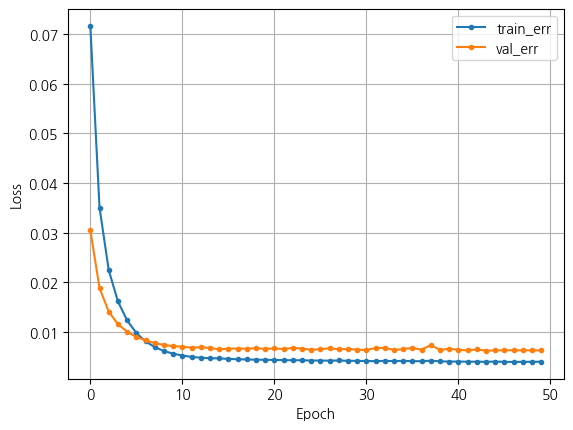

In [176]:
model12_02.compile(optimizer = 'adam', loss = 'mse')
hist = model12_02.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [177]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
MAE :  1686.6300903320312
MAPE :  0.13255357027633952
R2 :  0.6204142933242283


In [178]:
rmse = mean_squared_error(y_val2, pred, squared=False)
mae = mean_absolute_error(y_val2, pred)
mape = mean_absolute_percentage_error(y_val2, pred)
r2 = r2_score(y_val2, pred)

print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

┌─────────┬────────────────┐
│ Metric  │         Value  │
├─────────┼────────────────┤
│ RMSE    │      2211.3166 │
├─────────┼────────────────┤
│ MAE     │      1686.6301 │
├─────────┼────────────────┤
│ MAPE    │       13.2554% │
├─────────┼────────────────┤
│ R2      │         0.6204 │
└─────────┴────────────────┘


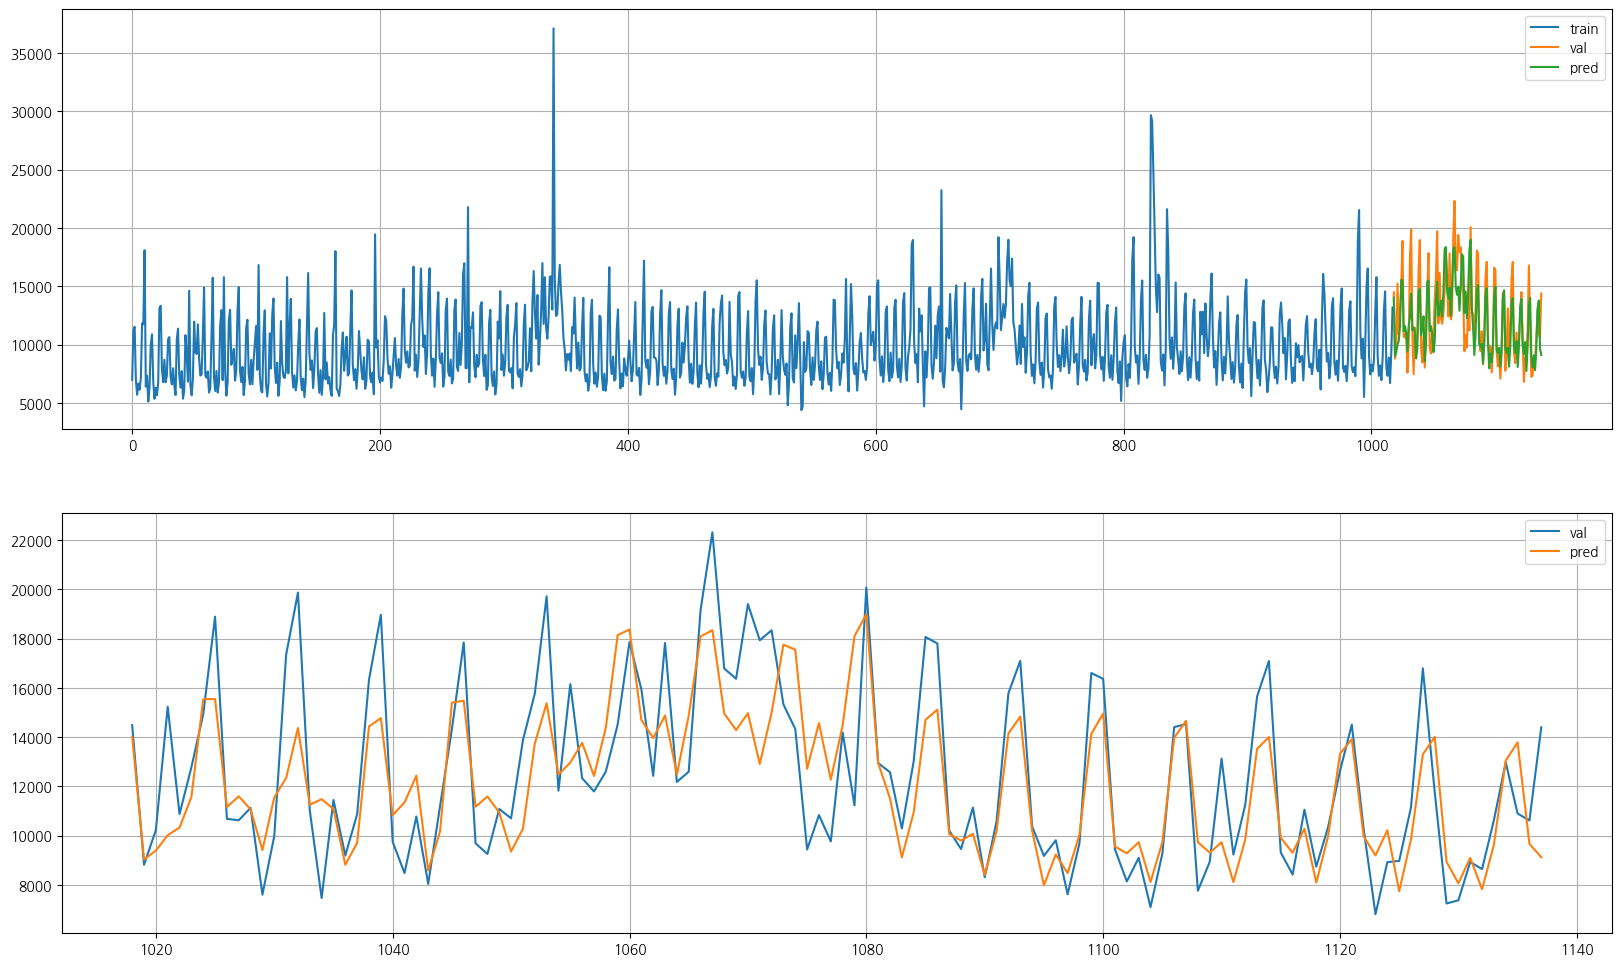

In [179]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [180]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(base_12, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(4390.0, 37106.0, (1018, 7, 31), (120, 7, 31))

* **모델링**

In [186]:
clear_session()

_, ts, nfeat = x_train.shape

model12_01 = Sequential([Conv1D(4, 3, input_shape = (ts, nfeat), activation='relu', padding = 'same'),
                         Flatten(),
                         Dense(1)])
model12_01.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 7, 4)                │             376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              29 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 405 (1.58 KB)

 Trainable params: 405 (1.58 KB)

 Non-trainable params: 0 (0.00 B)

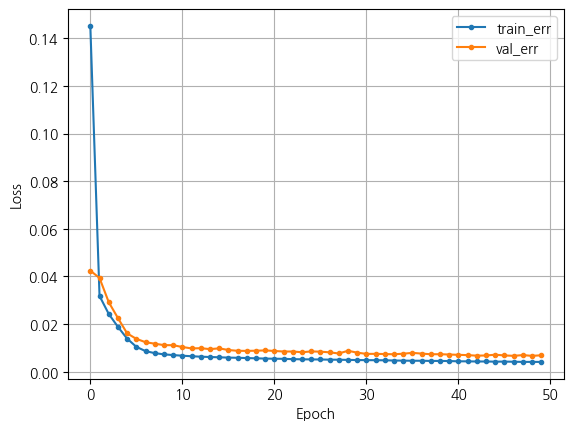

In [187]:
model12_01.compile(optimizer = 'adam', loss = 'mse')
hist = model12_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [188]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE :  2338.5112548828124
MAPE :  0.17933241053739243
R2 :  0.3322651522786523


In [189]:
rmse = mean_squared_error(y_val2, pred, squared=False)
mae = mean_absolute_error(y_val2, pred)
mape = mean_absolute_percentage_error(y_val2, pred)
r2 = r2_score(y_val2, pred)

print("┌─────────┬────────────────┐")
print(f"│ Metric  │         Value  │")
print("├─────────┼────────────────┤")
print(f"│ RMSE    │ {rmse:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAE     │ {mae:14.4f} │")
print("├─────────┼────────────────┤")
print(f"│ MAPE    │ {mape:14.4%} │")
print("├─────────┼────────────────┤")
print(f"│ R2      │ {r2:14.4f} │")
print("└─────────┴────────────────┘")

┌─────────┬────────────────┐
│ Metric  │         Value  │
├─────────┼────────────────┤
│ RMSE    │      2932.9052 │
├─────────┼────────────────┤
│ MAE     │      2338.5113 │
├─────────┼────────────────┤
│ MAPE    │       17.9332% │
├─────────┼────────────────┤
│ R2      │         0.3323 │
└─────────┴────────────────┘


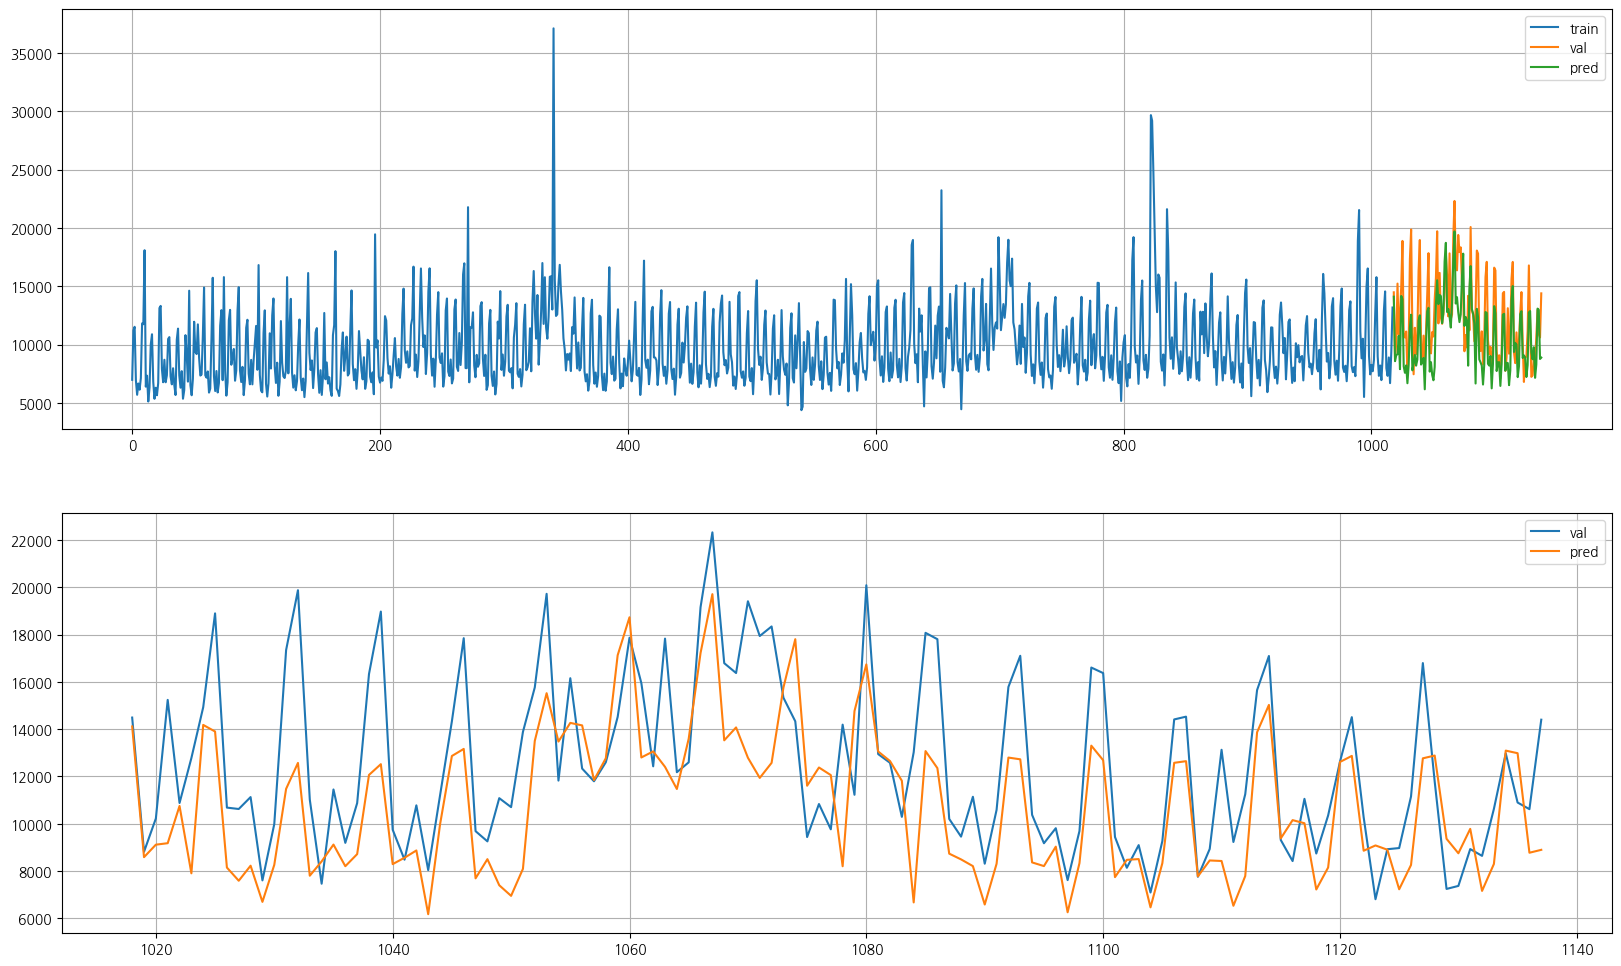

In [190]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [131]:
import joblib

#joblib.dump(base_3, path + 'data03.pkl')
#joblib.dump(base_12, path + 'data12.pkl')
joblib.dump(base_42, path + 'data42.pkl')

['/content/drive/MyDrive/project/data42.pkl']

In [90]:
df_3 = joblib.load(path + 'data03.pkl')
df_3

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9853.0,7109.454545,8807.200000,No,No,No,Thursday,1,10142.0,45969,15153.0
1,2014-01-03,4167,8647.0,7109.454545,8807.200000,No,No,No,Friday,1,8980.0,42386,15606.0
2,2014-01-04,5341,15153.0,13476.000000,8807.200000,No,No,No,Saturday,1,15684.0,52293,7900.0
3,2014-01-05,5123,15606.0,13476.000000,8807.200000,No,No,No,Sunday,1,15606.0,49199,7188.0
4,2014-01-06,3917,7900.0,7109.454545,8807.200000,No,No,No,Monday,1,8083.0,39105,8800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,7856.0,8994.050000,10487.607143,No,No,No,Wednesday,2,8118.0,38673,10208.0
1140,2017-02-23,3955,8018.0,8994.050000,10487.607143,No,No,No,Thursday,2,8316.0,39881,12361.0
1141,2017-02-24,4549,10208.0,8994.050000,10487.607143,No,No,No,Friday,2,10689.0,43170,10108.0
1142,2017-02-25,4619,12361.0,14221.500000,10487.607143,No,No,No,Saturday,2,13073.0,46801,10006.0


In [94]:
df_12 = joblib.load(path + 'data12.pkl')
df_12

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,9647.0,7385.727273,8614.133333,No,No,No,Thursday,1,15195.550,45969,14188.0
1,2014-01-03,4167,8879.0,7385.727273,8614.133333,No,No,No,Friday,1,13952.689,42386,14490.0
2,2014-01-04,5341,14188.0,11992.250000,8614.133333,No,No,No,Saturday,1,22059.125,52293,7614.0
3,2014-01-05,5123,14490.0,11992.250000,8614.133333,No,No,No,Sunday,1,22443.851,49199,7124.0
4,2014-01-06,3917,7614.0,7385.727273,8614.133333,No,No,No,Monday,1,11853.281,39105,8683.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,8931.0,9774.000000,10993.178571,No,No,No,Wednesday,2,13281.361,38673,10630.0
1140,2017-02-23,3955,8643.0,9774.000000,10993.178571,No,No,No,Thursday,2,12888.873,39881,12978.0
1141,2017-02-24,4549,10630.0,9774.000000,10993.178571,No,No,No,Friday,2,15817.968,43170,10899.0
1142,2017-02-25,4619,12978.0,14041.125000,10993.178571,No,No,No,Saturday,2,19393.951,46801,10618.0


In [132]:
df_42= joblib.load(path + 'data42.pkl')
df_42

,Date,CustomerCount,Qty,DayType_Sales,Monthly_Sales,H_D,H_D_1,H_D_2,WeekDay,Month,Category_Qty,City_CustCount,target
0,2014-01-02,4422,76.0,70.681818,73.333333,No,No,No,Thursday,1,1962.622000,45969,78.0
1,2014-01-03,4167,74.0,70.681818,73.333333,No,No,No,Friday,1,2144.997000,42386,88.0
2,2014-01-04,5341,78.0,80.625000,73.333333,No,No,No,Saturday,1,2773.830000,52293,65.0
3,2014-01-05,5123,88.0,80.625000,73.333333,No,No,No,Sunday,1,2542.787000,49199,78.0
4,2014-01-06,3917,65.0,70.681818,73.333333,No,No,No,Monday,1,1284.361970,39105,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,2017-02-22,3834,72.0,87.800000,93.035714,No,No,No,Wednesday,2,1372.673000,38673,91.0
1140,2017-02-23,3955,98.0,87.800000,93.035714,No,No,No,Thursday,2,1399.130996,39881,105.0
1141,2017-02-24,4549,91.0,87.800000,93.035714,No,No,No,Friday,2,2426.355000,43170,108.0
1142,2017-02-25,4619,105.0,106.125000,93.035714,No,No,No,Saturday,2,2267.651000,46801,78.0
